<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google-research-datasets/scin/blob/main/scin_demo.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/google-research-datasets/scin/"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In [ ]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## SCIN dataset demo

This colab demos how to load the SCIN dataset from the CSV files in Google Cloud Storage.


## Setup

In [ ]:
pip install tabulate


In [ ]:
import google

In [ ]:
#@title Imports

import collections
import copy
import hashlib
import io
import os
import subprocess
import textwrap
import time

from typing import List, Text

from PIL import Image

import numpy as np
import pandas as pd
import tabulate


import tensorflow as tf

import matplotlib.pyplot as plt


### Authenticate


The following cell is for Colab only. If running elsewhere, authenticate with the [gcloud CLI](https://cloud.google.com/sdk/gcloud/reference/auth/login).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install google-cloud-storage

Note: you may need to restart the kernel to use updated packages.


In [ ]:
!gsutil -m cp -r gs://dx-scin-public-data/dataset/images/ "/content/drive/MyDrive/extracted_data/"

Streaming output truncated to the last 5000 lines.
Copying gs://dx-scin-public-data/dataset/images/1161010728027923477.png...
Copying gs://dx-scin-public-data/dataset/images/1163055688177342485.png...
Copying gs://dx-scin-public-data/dataset/images/1164646982557605400.png...
Copying gs://dx-scin-public-data/dataset/images/1166247335471414448.png...
Copying gs://dx-scin-public-data/dataset/images/1166910403207296452.png...
Copying gs://dx-scin-public-data/dataset/images/1168621935293681649.png...
Copying gs://dx-scin-public-data/dataset/images/1168929444582863219.png...
Copying gs://dx-scin-public-data/dataset/images/1170860713860235539.png...
Copying gs://dx-scin-public-data/dataset/images/1172367779008852489.png...
Copying gs://dx-scin-public-data/dataset/images/1173280857169999078.png...
Copying gs://dx-scin-public-data/dataset/images/1174067969932849040.png...
Copying gs://dx-scin-public-data/dataset/images/1175687802305842761.png...
Copying gs://dx-scin-public-data/dataset/images/1

In [ ]:
!gsutil -m cp -r gs://dx-scin-public-data/dataset/scin_cases.csv/ "/content/drive/MyDrive/extracted_data/"

Copying gs://dx-scin-public-data/dataset/scin_cases.csv...
/ [1/1 files][  1.2 MiB/  1.2 MiB] 100% Done                                    
Operation completed over 1 objects/1.2 MiB.                                      


In [ ]:
!gsutil -m cp -r gs://dx-scin-public-data/dataset/scin_labels.csv/ "/content/drive/MyDrive/extracted_data/"

Copying gs://dx-scin-public-data/dataset/scin_labels.csv...
/ [1/1 files][874.7 KiB/874.7 KiB] 100% Done                                    
Operation completed over 1 objects/874.7 KiB.                                    


### Configuration

In [ ]:
  # CSV of case metadata to read
cases_csv = '/content/drive/MyDrive/extracted_data/scin_cases.csv' #@param

  # CSV of label metadata to read
labels_csv = '/content/drive/MyDrive/extracted_data/scin_labels.csv' #@param

  # Images directory
gcs_images_dir = '/content/drive/MyDrive/extracted_data/images' #@param

  ### Key column names
image_path_columns = ['image_1_path', 'image_2_path', 'image_3_path']
weighted_skin_condition_label = "weighted_skin_condition_label"
skin_condition_label = "dermatologist_skin_condition_on_label_name"

  ###### Formed during execution:

  # Client for querying GCS

## Load dataset

In [ ]:
#@title Create a dataframe that contains the metadata and condition labels

import pandas as pd

def initialize_df_with_metadata(csv_path):
  """Loads the given CSV into a pd.DataFrame."""
  df = pd.read_csv(csv_path, dtype={'case_id': str})
  df['case_id'] = df['case_id'].astype(str)
  return df

def augment_metadata_with_labels(df, csv_path):
  """Loads the given CSV into a pd.DataFrame."""
  labels_df = pd.read_csv(csv_path, dtype={'case_id': str})
  labels_df['case_id'] = labels_df['case_id'].astype(str)
  merged_df = pd.merge(df, labels_df, on='case_id')
  return merged_df

# Replace with the actual paths to your CSV files in your Google Drive:
cases_csv = '/content/drive/MyDrive/extracted_data/scin_cases.csv'  #@param
labels_csv = '/content/drive/MyDrive/extracted_data/scin_labels.csv'  #@param

cases_df = initialize_df_with_metadata(cases_csv)
cases_and_labels_df = augment_metadata_with_labels(cases_df, labels_csv)
print(len(cases_and_labels_df))

5033


In [ ]:
cases_and_labels_df.columns

Index(['case_id', 'source', 'release', 'year', 'age_group', 'sex_at_birth',
       'fitzpatrick_skin_type',
       'race_ethnicity_american_indian_or_alaska_native',
       'race_ethnicity_asian', 'race_ethnicity_black_or_african_american',
       'race_ethnicity_hispanic_latino_or_spanish_origin',
       'race_ethnicity_middle_eastern_or_north_african',
       'race_ethnicity_native_hawaiian_or_pacific_islander',
       'race_ethnicity_white', 'race_ethnicity_other_race',
       'race_ethnicity_prefer_not_to_answer', 'textures_raised_or_bumpy',
       'textures_flat', 'textures_rough_or_flaky', 'textures_fluid_filled',
       'body_parts_head_or_neck', 'body_parts_arm', 'body_parts_palm',
       'body_parts_back_of_hand', 'body_parts_torso_front',
       'body_parts_torso_back', 'body_parts_genitalia_or_groin',
       'body_parts_buttocks', 'body_parts_leg', 'body_parts_foot_top_or_side',
       'body_parts_foot_sole', 'body_parts_other',
       'condition_symptoms_bothersome_appearan

In [ ]:
cases_and_labels_df.sample(5
                                   )

,case_id,source,release,year,age_group,sex_at_birth,fitzpatrick_skin_type,race_ethnicity_american_indian_or_alaska_native,race_ethnicity_asian,race_ethnicity_black_or_african_american,...,dermatologist_gradable_for_fitzpatrick_skin_type_1,dermatologist_gradable_for_fitzpatrick_skin_type_2,dermatologist_gradable_for_fitzpatrick_skin_type_3,dermatologist_fitzpatrick_skin_type_label_1,dermatologist_fitzpatrick_skin_type_label_2,dermatologist_fitzpatrick_skin_type_label_3,gradable_for_monk_skin_tone_india,gradable_for_monk_skin_tone_us,monk_skin_tone_label_india,monk_skin_tone_label_us
403,-2257423882813548775,SCIN,1.0.0,2023,AGE_UNKNOWN,OTHER_OR_UNSPECIFIED,NaN,NaN,NaN,NaN,...,YES,NaN,NaN,FST2,NaN,NaN,True,True,2.0,3.0
234,-1733088243273090927,SCIN,1.0.0,2023,AGE_40_TO_49,FEMALE,FST2,NaN,NaN,NaN,...,YES,YES,YES,FST3,FST3,FST3,True,True,2.0,2.0
3793,5271771538970840283,SCIN,1.0.0,2023,AGE_30_TO_39,FEMALE,FST3,NaN,NaN,NaN,...,YES,NaN,NaN,FST2,NaN,NaN,True,True,2.0,2.0
2305,-8543815658932102792,SCIN,1.0.0,2023,AGE_30_TO_39,FEMALE,FST2,NaN,NaN,NaN,...,YES,NaN,NaN,FST2,NaN,NaN,True,True,2.0,3.0
1645,-6389849460848982301,SCIN,1.0.0,2023,AGE_UNKNOWN,OTHER_OR_UNSPECIFIED,NaN,NaN,NaN,NaN,...,YES,NaN,NaN,FST2,NaN,NaN,True,True,4.0,4.0


In [ ]:
cases_and_labels_df["dermatologist_skin_condition_on_label_name"].head()



,dermatologist_skin_condition_on_label_name
0,"['Inflicted skin lesions', 'Eczema', 'Irritant..."
1,"['Prurigo nodularis', 'Actinic Keratosis', 'SC..."
2,"['Impetigo', 'Herpes Zoster', 'Bullous dermati..."
3,[]
4,"['Lichen planus/lichenoid eruption', 'Follicul..."


In [ ]:
cases_and_labels_df["weighted_skin_condition_label"].head()

,weighted_skin_condition_label
0,"{'Inflicted skin lesions': 0.41, 'Eczema': 0.4..."
1,"{'Prurigo nodularis': 0.41, 'SCC/SCCIS': 0.41,..."
2,"{'Impetigo': 0.55, 'Herpes Zoster': 0.23, 'Bul..."
3,{}
4,"{'Lichen planus/lichenoid eruption': 0.33, 'Fo..."


## Get familiar with the data

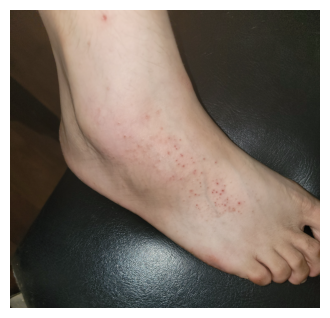

In [ ]:
import os
import io
from google.colab import drive
from PIL import Image

# ... other imports ...

def display_image(image_path):
  """Displays an image using Matplotlib."""
  # Construct the full image path using gcs_images_dir
  full_image_path = os.path.join(gcs_images_dir, image_path)
  try:
    image = Image.open(full_image_path)
    figure_size = 4
    f, axarr = plt.subplots(1, 1, figsize=(figure_size, figure_size))
    axarr.imshow(image, cmap='gray')
    axarr.axis('off')
    plt.show()
  except FileNotFoundError:
    print(f"Error: Image not found at {full_image_path}")

def display_images_for_case(df, case_id="", print_condition_labels=True):
  # Assuming you want to display images for the first case in the DataFrame if case_id is not provided
  matched_df = df.head(1)  # Selects the first row of the DataFrame
  # ... (rest of the function remains the same) ...
  image_paths = matched_df[image_path_columns].values.tolist()[0]
  for path in image_paths:
    if isinstance(path, str):
      # Pass the image path relative to gcs_images_dir
      display_image(os.path.basename(path))
  # ... (rest of the function remains the same) ...

# Example usage:
display_images_for_case(cases_and_labels_df)

In [ ]:
#@title Print metadata stats
def print_metadata_stats(df: pd.DataFrame) -> None:
  print(f'Num cases: {len(df)}')

  # Number of cases with 1, 2, or 3 images
  image_1_cnt = df["image_1_path"].count()
  image_2_cnt = df["image_2_path"].count()
  image_3_cnt = df["image_3_path"].count()
  print(f'Num cases with image_1_path set: {image_1_cnt}')
  print(f'Num cases with image_2_path set: {image_2_cnt}')
  print(f'Num cases with image_3_path set: {image_3_cnt}')
  print(f'Total images: {image_1_cnt + image_2_cnt + image_3_cnt}')

  # Sex at birth:
  print('\nSelf-reported Sex at Birth:')
  sab = collections.Counter(df['sex_at_birth'].dropna())
  total = sum(sab.values())
  for k in sorted(sab):
    print(f'  {k} {sab[k]} ({100.0*sab[k]/total:.1f}%)')

  # FST distribution:
  print('\nSelf-reported Fitzpatrick Skin Type:')
  fst = collections.Counter(df['fitzpatrick_skin_type'].dropna())
  total = sum(fst.values())
  for k in sorted(fst):
    print(f'  {k} {fst[k]} ({100.0*fst[k]/total:.1f}%)')


print_metadata_stats(cases_and_labels_df)

Num cases: 5033
Num cases with image_1_path set: 5033
Num cases with image_2_path set: 3085
Num cases with image_3_path set: 2289
Total images: 10407

Self-reported Sex at Birth:
  FEMALE 1666 (33.1%)
  MALE 807 (16.0%)
  OTHER_OR_UNSPECIFIED 2559 (50.9%)

Self-reported Fitzpatrick Skin Type:
  FST1 188 (7.5%)
  FST2 542 (21.7%)
  FST3 661 (26.4%)
  FST4 427 (17.1%)
  FST5 214 (8.5%)
  FST6 143 (5.7%)
  NONE_IDENTIFIED 328 (13.1%)


In [ ]:
#@title Add combined_race_ethnicity column

def merge_race_ethnicity_columns(row):
  combined = []
  for col in row.keys():
    if col.startswith("race_ethnicity_") and row[col] == 'YES':
      combined.append(col[len("race_ethnicity_"):])
  return ",".join(combined)

cases_and_labels_df["combined_race_ethnicity"] = cases_and_labels_df.apply(merge_race_ethnicity_columns, axis=1)
cases_and_labels_df[["case_id", "combined_race_ethnicity"]]

,case_id,combined_race_ethnicity
0,-1000600354148496558,
1,-1002039107727665188,
2,-1003358831658393077,hispanic_latino_or_spanish_origin
3,-1003826561155964328,
4,-1003844406100696311,white
...,...,...
5028,973759811984683137,two_or_more_after_mitigation
5029,973872028150293734,
5030,983265958160210646,black_or_african_american
5031,995820220956352730,two_or_more_after_mitigation


In [ ]:
#@title Print race/ethnicity distribution

def print_race_ethnicity_dist(df):
  c = collections.Counter(df['combined_race_ethnicity'].dropna())
  total = sum(c.values())
  for k in sorted(c):
    if not k:
      k = 'unspecified'
    print(f'  {k}: {c[k]} ({100.0*c[k]/total:.1f}%)')

print_race_ethnicity_dist(cases_and_labels_df)

  unspecified: 0 (0.0%)
  american_indian_or_alaska_native: 48 (1.0%)
  american_indian_or_alaska_native,white: 25 (0.5%)
  asian: 85 (1.7%)
  asian,white: 11 (0.2%)
  black_or_african_american: 267 (5.3%)
  black_or_african_american,hispanic_latino_or_spanish_origin: 11 (0.2%)
  black_or_african_american,white: 20 (0.4%)
  hispanic_latino_or_spanish_origin: 224 (4.5%)
  hispanic_latino_or_spanish_origin,white: 55 (1.1%)
  middle_eastern_or_north_african: 7 (0.1%)
  native_hawaiian_or_pacific_islander: 4 (0.1%)
  other_race: 16 (0.3%)
  prefer_not_to_answer: 34 (0.7%)
  two_or_more_after_mitigation: 83 (1.6%)
  white: 1762 (35.0%)


## Skin Condition label information

In [ ]:
#@title Print condition distribution

def print_condition_distribution(df, top_n_conditions=50):
  # Any condition that shows up in a label
  condition_ctr = collections.Counter()
  print(f'Distribution of conditions in "{skin_condition_label}" column:')
  for entry in df[skin_condition_label].dropna():
    condition_ctr.update(eval(entry))
  for condition, cnt in condition_ctr.most_common()[:top_n_conditions]:
    print(f'  {condition}: {cnt}')
  print(f'Distribution of conditions in "{weighted_skin_condition_label}" column:')
  weighted_condition_ctr = collections.Counter()
  for entry in df[weighted_skin_condition_label].dropna():
    weighted_condition_ctr.update(eval(entry).keys())
  for condition, cnt in weighted_condition_ctr.most_common()[:top_n_conditions]:
    print(f'  {condition}: {cnt}')

print_condition_distribution(cases_and_labels_df)


Distribution of conditions in "dermatologist_skin_condition_on_label_name" column:
  Eczema: 1211
  Allergic Contact Dermatitis: 952
  Insect Bite: 449
  Urticaria: 377
  Psoriasis: 348
  Folliculitis: 297
  Irritant Contact Dermatitis: 254
  Tinea: 232
  Herpes Zoster: 157
  Drug Rash: 156
  Herpes Simplex: 152
  Impetigo: 124
  Acute dermatitis, NOS: 124
  Hypersensitivity: 115
  Acne: 109
  Pigmented purpuric eruption: 108
  Leukocytoclastic Vasculitis: 105
  Lichen planus/lichenoid eruption: 94
  Pityriasis rosea: 89
  Viral Exanthem: 87
  Lichen Simplex Chronicus: 85
  Stasis Dermatitis: 83
  Keratosis pilaris: 72
  CD - Contact dermatitis: 70
  Scabies: 68
  Tinea Versicolor: 68
  Granuloma annulare: 65
  Molluscum Contagiosum: 64
  Rosacea: 57
  Abrasion, scrape, or scab: 51
  O/E - ecchymoses present: 51
  Seborrheic Dermatitis: 50
  Acute and chronic dermatitis: 47
  Photodermatitis: 45
  Cellulitis: 45
  Abscess: 43
  Verruca vulgaris: 42
  SCC/SCCIS: 38
  Purpura: 38
  Inter

In [ ]:
#@title Print column names
print(cases_and_labels_df.columns)

Index(['case_id', 'source', 'release', 'year', 'age_group', 'sex_at_birth',
       'fitzpatrick_skin_type',
       'race_ethnicity_american_indian_or_alaska_native',
       'race_ethnicity_asian', 'race_ethnicity_black_or_african_american',
       'race_ethnicity_hispanic_latino_or_spanish_origin',
       'race_ethnicity_middle_eastern_or_north_african',
       'race_ethnicity_native_hawaiian_or_pacific_islander',
       'race_ethnicity_white', 'race_ethnicity_other_race',
       'race_ethnicity_prefer_not_to_answer', 'textures_raised_or_bumpy',
       'textures_flat', 'textures_rough_or_flaky', 'textures_fluid_filled',
       'body_parts_head_or_neck', 'body_parts_arm', 'body_parts_palm',
       'body_parts_back_of_hand', 'body_parts_torso_front',
       'body_parts_torso_back', 'body_parts_genitalia_or_groin',
       'body_parts_buttocks', 'body_parts_leg', 'body_parts_foot_top_or_side',
       'body_parts_foot_sole', 'body_parts_other',
       'condition_symptoms_bothersome_appearan

## Display distributions of self-reported condition info

Distribution data: {'arm': 1707, 'leg': 1694, 'torso_front': 795, 'head_or_neck': 737, 'torso_back': 652, 'other': 543, 'back_of_hand': 521, 'foot_top_or_side': 415, 'buttocks': 391, 'genitalia_or_groin': 222, 'palm': 215, 'foot_sole': 104}


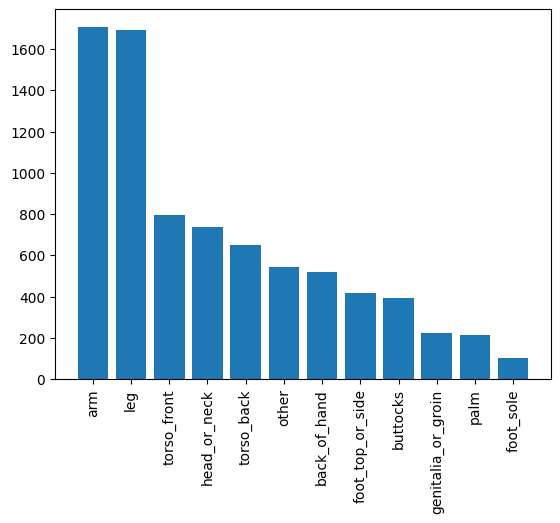

In [ ]:
#@title Display body part distribution

def get_distribution_columns(df, prefix):
  cols = [c for c in df.columns if c.startswith(prefix)]
  dist = collections.Counter()
  for c in cols:
    name = c[len(prefix):]
    val = sum(df[c] == "YES")
    dist[name] = val
  return dist

def get_distribution_and_display(df, prefix):
  ctr = get_distribution_columns(df, prefix)
  dist = dict(ctr.most_common())
  print(f'Distribution data: {dist}')
  names = list(dist.keys())
  counts = list(dist.values())
  plt.bar(names, counts)
  plt.xticks(rotation=90)  # Rotate labels by 90 degrees
  plt.show()

# Distribution data: {'arm': 1707, 'leg': 1694, 'torso_front': 795, 'head_or_neck': 737, 'torso_back': 652, 'other': 543, 'back_of_hand': 521, 'foot_top_or_side': 415, 'buttocks': 391, 'genitalia_or_groin': 222, 'palm': 215, 'foot_sole': 104}
get_distribution_and_display(cases_and_labels_df, "body_parts_")


Distribution data: {'raised_or_bumpy': 2915, 'rough_or_flaky': 1032, 'flat': 822, 'fluid_filled': 629}


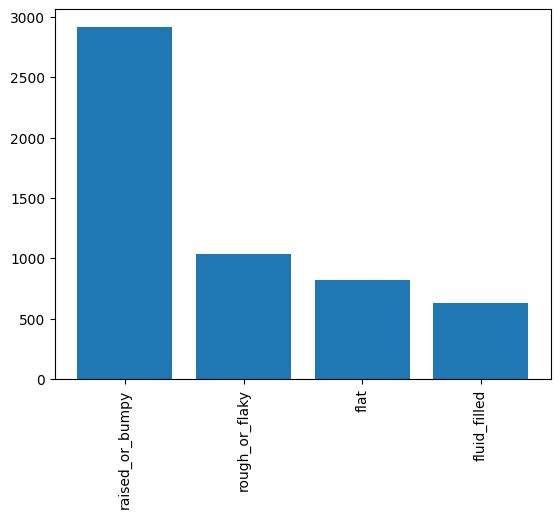

In [ ]:
#@title Display texture distribution
get_distribution_and_display(cases_and_labels_df, "textures_")

Distribution data: {'itching': 2712, 'bothersome_appearance': 1530, 'increasing_size': 1013, 'burning': 988, 'pain': 734, 'darkening': 385, 'no_relevant_experience': 308, 'bleeding': 225}


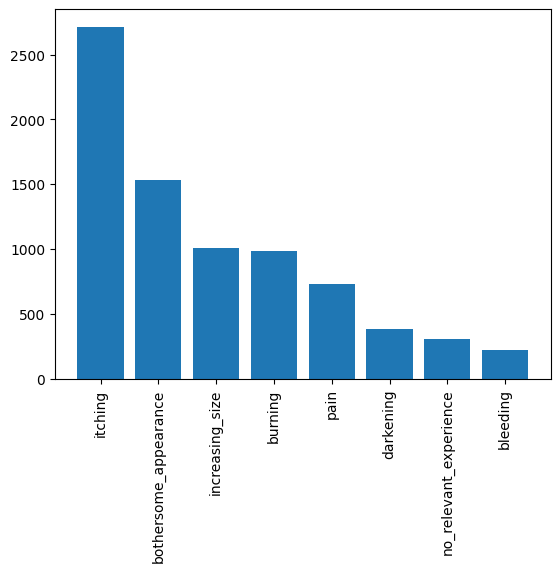

In [ ]:
#@title Display condition symptom dist
get_distribution_and_display(cases_and_labels_df, "condition_symptoms_")

Distribution data: {'no_relevant_symptoms': 2841, 'fatigue': 415, 'joint_pain': 300, 'shortness_of_breath': 139, 'chills': 120, 'mouth_sores': 96, 'fever': 90}


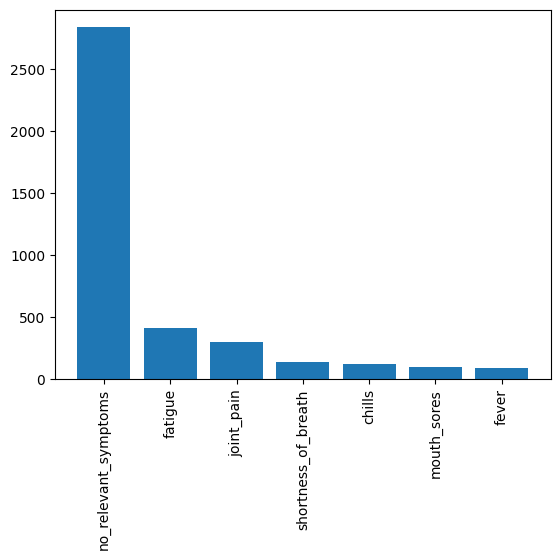

In [ ]:
#@title Display other symptoms distribution
get_distribution_and_display(cases_and_labels_df, "other_symptoms_")

In [ ]:
# @title
cases_and_labels_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5033 entries, 0 to 5032
Data columns (total 74 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   case_id                                             5033 non-null   object 
 1   source                                              5033 non-null   object 
 2   release                                             5033 non-null   object 
 3   year                                                5033 non-null   int64  
 4   age_group                                           5032 non-null   object 
 5   sex_at_birth                                        5032 non-null   object 
 6   fitzpatrick_skin_type                               2503 non-null   object 
 7   race_ethnicity_american_indian_or_alaska_native     73 non-null     object 
 8   race_ethnicity_asian                                96 non-null     object 
 9

In [ ]:
# @title
# prompt: find all categorical columns and apply encoding to categorical columns in cases_and_labels_df

import pandas as pd
from sklearn.preprocessing import LabelEncoder



In [ ]:
# @title
categorical_cols = [col for col in cases_and_labels_df.select_dtypes(include=['object']).columns if col not in ["case_id", "weighted_skin_condition_label"]]
categorical_cols

['source',
 'release',
 'age_group',
 'sex_at_birth',
 'fitzpatrick_skin_type',
 'race_ethnicity_american_indian_or_alaska_native',
 'race_ethnicity_asian',
 'race_ethnicity_black_or_african_american',
 'race_ethnicity_hispanic_latino_or_spanish_origin',
 'race_ethnicity_middle_eastern_or_north_african',
 'race_ethnicity_native_hawaiian_or_pacific_islander',
 'race_ethnicity_white',
 'race_ethnicity_other_race',
 'race_ethnicity_prefer_not_to_answer',
 'textures_raised_or_bumpy',
 'textures_flat',
 'textures_rough_or_flaky',
 'textures_fluid_filled',
 'body_parts_head_or_neck',
 'body_parts_arm',
 'body_parts_palm',
 'body_parts_back_of_hand',
 'body_parts_torso_front',
 'body_parts_torso_back',
 'body_parts_genitalia_or_groin',
 'body_parts_buttocks',
 'body_parts_leg',
 'body_parts_foot_top_or_side',
 'body_parts_foot_sole',
 'body_parts_other',
 'condition_symptoms_bothersome_appearance',
 'condition_symptoms_bleeding',
 'condition_symptoms_increasing_size',
 'condition_symptoms_dar

In [ ]:
# @title
numerical_cols = cases_and_labels_df.select_dtypes(include=['int64', 'float64']).columns
print(numerical_cols)

Index(['year', 'monk_skin_tone_label_india', 'monk_skin_tone_label_us'], dtype='object')


In [ ]:
# @title
le = LabelEncoder()
for col in categorical_cols:
  if col not in image_path_columns: #skip image paths
    cases_and_labels_df[col] = le.fit_transform(cases_and_labels_df[col].astype(str))

print(cases_and_labels_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5033 entries, 0 to 5032
Data columns (total 74 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   case_id                                             5033 non-null   object 
 1   source                                              5033 non-null   int64  
 2   release                                             5033 non-null   int64  
 3   year                                                5033 non-null   int64  
 4   age_group                                           5033 non-null   int64  
 5   sex_at_birth                                        5033 non-null   int64  
 6   fitzpatrick_skin_type                               5033 non-null   int64  
 7   race_ethnicity_american_indian_or_alaska_native     5033 non-null   int64  
 8   race_ethnicity_asian                                5033 non-null   int64  
 9

In [ ]:
# @title
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# @title
scaler = MinMaxScaler()
cases_and_labels_df[numerical_cols] = scaler.fit_transform(cases_and_labels_df[numerical_cols])
print(cases_and_labels_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5033 entries, 0 to 5032
Data columns (total 74 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   case_id                                             5033 non-null   object 
 1   source                                              5033 non-null   int64  
 2   release                                             5033 non-null   int64  
 3   year                                                5033 non-null   float64
 4   age_group                                           5033 non-null   int64  
 5   sex_at_birth                                        5033 non-null   int64  
 6   fitzpatrick_skin_type                               5033 non-null   int64  
 7   race_ethnicity_american_indian_or_alaska_native     5033 non-null   int64  
 8   race_ethnicity_asian                                5033 non-null   int64  
 9

In [ ]:
# @title
cases_and_labels_df["image_1_path"]

,image_1_path
0,dataset/images/-3205742176803893704.png
1,dataset/images/-4762289084741430925.png
2,dataset/images/-4027806997035329030.png
3,dataset/images/-5332065579713135540.png
4,dataset/images/-3799298995660217860.png
...,...
5028,dataset/images/32575980331712012.png
5029,dataset/images/-5315065439551573643.png
5030,dataset/images/-4723634841049886674.png
5031,dataset/images/-3758258982362095839.png


In [ ]:
import tensorflow as tf

## Use this code to download SCIN data for image preprocessing

Need to build SCIN model

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer, OneHotEncoder, StandardScaler
from tensorflow.keras.utils import to_categorical
import numpy as np

Run the code below once to process and save the images

In [ ]:
@title
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm

# Define paths
BASE_PATH = "/content/drive/MyDrive/"
SAVE_PATH = "/content/drive/MyDrive/dataset/preprocessed_img/"  # Directory to save processed images

# Create directory if it doesn't exist
os.makedirs(SAVE_PATH, exist_ok=True)

# Image size
IMG_SIZE = (224, 224)

# Ensure correct image columns
image_columns = ["image_1_path", "image_2_path", "image_3_path"]

# Function to load and save preprocessed images
def load_and_save_images(row):
    images = []

    for i, col in enumerate(image_columns, start=1):
        img_path = row[col]
        if pd.notna(img_path):  # Ensure path exists
            full_path = os.path.join(BASE_PATH, img_path)
            if os.path.exists(full_path):
                img = cv2.imread(full_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
                img = cv2.resize(img, IMG_SIZE)  # Resize
                img = img / 255.0  # Normalize

                # Save processed image
                save_filename = f"{row['case_id']}_img{i}.jpg"  # Unique filename
                save_path = os.path.join(SAVE_PATH, save_filename)
                cv2.imwrite(save_path, (img * 255).astype(np.uint8))  # Convert back to uint8 before saving

                images.append(save_path)  # Store saved path instead of array

    if not images:
        print(f"No valid images found for case_id: {row['case_id']}")
        images.append(None)  # Placeholder for missing images

    return images  # Return list of saved image paths

# Apply function with tqdm progress bar
tqdm.pandas(desc="Processing & Saving Images")
cases_and_labels_df["processed_images"] = cases_and_labels_df.progress_apply(load_and_save_images, axis=1)

print("Preprocessed images saved successfully!")


In [ ]:
# @title
# prompt: count the number of images in /content/drive/MyDrive/dataset/preprocessed_img

import os

image_dir = "/content/drive/MyDrive/dataset/preprocessed_img"
image_count = 0

# Iterate through files in the directory
for filename in os.listdir(image_dir):
    # Check if the file is an image (you can add more extensions if needed)
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
        image_count += 1

print(f"Number of images in '{image_dir}': {image_count}")


Number of images in '/content/drive/MyDrive/dataset/preprocessed_img': 10406


In [ ]:
# @title
# Check if 'images' exists
print(f"Columns in DataFrame: {cases_and_labels_df.columns}")

# Check if 'images' is present before accessing it
if "images" in cases_and_labels_df.columns:
    print(cases_and_labels_df[["case_id", "image_1_path", "images"]].head())
else:
    print("⚠️ Column 'images' does not exist! Ensure load_images() was applied.")



Columns in DataFrame: Index(['case_id', 'source', 'release', 'year', 'age_group', 'sex_at_birth',
       'fitzpatrick_skin_type',
       'race_ethnicity_american_indian_or_alaska_native',
       'race_ethnicity_asian', 'race_ethnicity_black_or_african_american',
       'race_ethnicity_hispanic_latino_or_spanish_origin',
       'race_ethnicity_middle_eastern_or_north_african',
       'race_ethnicity_native_hawaiian_or_pacific_islander',
       'race_ethnicity_white', 'race_ethnicity_other_race',
       'race_ethnicity_prefer_not_to_answer', 'textures_raised_or_bumpy',
       'textures_flat', 'textures_rough_or_flaky', 'textures_fluid_filled',
       'body_parts_head_or_neck', 'body_parts_arm', 'body_parts_palm',
       'body_parts_back_of_hand', 'body_parts_torso_front',
       'body_parts_torso_back', 'body_parts_genitalia_or_groin',
       'body_parts_buttocks', 'body_parts_leg', 'body_parts_foot_top_or_side',
       'body_parts_foot_sole', 'body_parts_other',
       'condition_sympto

In [ ]:
@title
import os
import cv2
import ast
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.layers import (Input, Dense, GlobalAveragePooling2D,
                                     GlobalAveragePooling1D, Concatenate, TimeDistributed)
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# ================================
# 1. Process Labels
# ================================

# Ensure all entries in weighted_skin_condition_label are dictionaries.
def safe_parse_labels(x):
    # If the value is a string, parse it; otherwise, assume it is already a dict.
    if isinstance(x, str):
        return ast.literal_eval(x)
    return x

cases_and_labels_df['weighted_skin_condition_label'] = cases_and_labels_df['weighted_skin_condition_label'].apply(safe_parse_labels)

# Extract all unique conditions
all_conditions = set()
cases_and_labels_df['weighted_skin_condition_label'].apply(lambda d: all_conditions.update(d.keys()))
all_conditions = sorted(all_conditions)
print(f"Found {len(all_conditions)} unique skin conditions.")

# Convert each label dict into a vector with one entry per condition.
def convert_labels(label_dict, all_conditions):
    vec = {cond: 0.0 for cond in all_conditions}
    for cond, weight in label_dict.items():
        vec[cond] = weight
    return vec

labels_series = cases_and_labels_df['weighted_skin_condition_label'].apply(lambda x: convert_labels(x, all_conditions))
labels_df = pd.DataFrame(labels_series.tolist())

# Create a DataFrame with case_id and label vectors
cases_and_labels_df_transformed = pd.concat([cases_and_labels_df[['case_id']], labels_df], axis=1)
y = cases_and_labels_df_transformed.drop(columns=['case_id']).values  # shape: (n_cases, n_conditions)
print(f"Labels shape: {y.shape}")


Found 370 unique skin conditions.
Labels shape: (5033, 370)


In [ ]:
# @title
cases_and_labels_df_transformed.head()

,case_id,AKV - Acrokeratosis verruciformis,Abrasion and/or friction burn of lower limb without infection,Abrasion and/or friction burn of thigh without infection,Abrasion of wrist,"Abrasion, scrape, or scab",Abscess,Acanthosis nigricans,Acne,Acne keloidalis,...,panniculitis of skin,pathergy,post-sunburn peeling/superficial desquamation,relapsing polychondritis,resolving dermatitis,scurvy,superficial hemorrhage,unilateral laterothoracic exanthem,varicose vein,wound/abrasion
0,-1000600354148496558,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1002039107727665188,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1003358831658393077,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1003826561155964328,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-1003844406100696311,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
@title
# Directory where preprocessed images were saved.
preprocessed_img_dir = "/content/drive/MyDrive/dataset/preprocessed_img"

def load_processed_images(case_id):
    """
    For each case_id, expects filenames:
      {case_id}_img1.jpg, {case_id}_img2.jpg, {case_id}_img3.jpg.
    Loads each available image.
    """
    images = []
    for i in range(1, 4):
        filename = f"{case_id}_img{i}.jpg"
        full_path = os.path.join(preprocessed_img_dir, filename)
        if os.path.exists(full_path):
            img = cv2.imread(full_path)
            # Convert BGR to RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img)
    return images

# Load images into the dataframe if the "images" column doesn't exist.
if 'images' not in cases_and_labels_df.columns:
    tqdm.pandas(desc="Loading Images")
    cases_and_labels_df['images'] = cases_and_labels_df['case_id'].progress_apply(load_processed_images)


### Map the conditions to categories

In [ ]:
import pickle

In [ ]:
# Save the DataFrame with the 'images' column
save_path = "/content/drive/MyDrive/dataset/cases_and_labels_df_with_images.pkl"
with open(save_path, 'wb') as f:
    pickle.dump(cases_and_labels_df, f)
print("DataFrame saved successfully!")

DataFrame loaded successfully!


In [ ]:
print(cases_and_labels_df['weighted_skin_condition_label'])

0       {'Inflicted skin lesions': 0.41, 'Eczema': 0.4...
1       {'Prurigo nodularis': 0.41, 'SCC/SCCIS': 0.41,...
2       {'Impetigo': 0.55, 'Herpes Zoster': 0.23, 'Bul...
3                                                      {}
4       {'Lichen planus/lichenoid eruption': 0.33, 'Fo...
                              ...                        
5028    {'CD - Contact dermatitis': 0.33, 'Allergic Co...
5029                                                   {}
5030               {'Impetigo': 0.5, 'Foreign body': 0.5}
5031    {'Erythema gyratum repens': 0.33, 'Seborrheic ...
5032                                {'Folliculitis': 1.0}
Name: weighted_skin_condition_label, Length: 5033, dtype: object


In [ ]:
# @title
condition_to_category = {
    # 1. Benign Skin Lesions
    'AKV - Acrokeratosis verruciformis': 'Benign Skin Lesions',
    'Acquired digital fibrokeratoma': 'Benign Skin Lesions',
    'Acquired poikiloderma': 'Benign Skin Lesions',
    'Acral persistent papular mucinosis': 'Benign Skin Lesions',
    'Epidermal nevus': 'Benign Skin Lesions',
    'Hemangioma': 'Benign Skin Lesions',
    'Melanocytic Nevus': 'Benign Skin Lesions',
    'Benign cutaneous vascular tumor': 'Benign Skin Lesions',
    'Benign tumor of dermis': 'Benign Skin Lesions',
    'SK/ISK': 'Benign Skin Lesions',
    'Collagenoma': 'Benign Skin Lesions',
    'Amyloidosis of skin': 'Benign Skin Lesions',
    'Lipoma': 'Benign Skin Lesions',
    'Angiokeratoma of skin': 'Benign Skin Lesions',
    'Tufted angioma of skin': 'Benign Skin Lesions',
    'Xanthoma': 'Benign Skin Lesions',
    'Mastocytoma': 'Benign Skin Lesions',
    'Neoplasm of uncertain behavior of skin of arm': 'Benign Skin Lesions',
    'Cutaneous polyarteritis nodosa': 'Benign Skin Lesions',
    'Panniculitis': 'Benign Skin Lesions',
    'Panniculitis, NOS': 'Benign Skin Lesions',
    'Pyogenic granuloma': 'Benign Skin Lesions',
    'Nodular vasculitis': 'Benign Skin Lesions',

    # 2. Eczema and Dermatitis
    'Eczema': 'Eczema and Dermatitis',
    'Acute and chronic dermatitis': 'Eczema and Dermatitis',
    'Acute constitutional eczema': 'Eczema and Dermatitis',
    'Acute dermatitis': 'Eczema and Dermatitis',
    'Acute dermatitis, NOS': 'Eczema and Dermatitis',
    'Acute generalised exanthematous pustulosis': 'Eczema and Dermatitis',
    'Acute vesicular dermatitis': 'Eczema and Dermatitis',
    'Acute-on-chronic dyshidrotic eczema of hands': 'Eczema and Dermatitis',
    'Allergic Contact Dermatitis': 'Eczema and Dermatitis',
    'Allergic contact dermatitis caused by allergenic hapten derived from plant': 'Eczema and Dermatitis',
    'Berloque dermatitis': 'Eczema and Dermatitis',
    'CD - Contact dermatitis': 'Eczema and Dermatitis',
    'Contact dermatitis caused by Rhus diversiloba': 'Eczema and Dermatitis',
    'Contact dermatitis, NOS': 'Eczema and Dermatitis',
    'Irritant Contact Dermatitis': 'Eczema and Dermatitis',
    'Seborrheic Dermatitis': 'Eczema and Dermatitis',
    'Perioral Dermatitis': 'Eczema and Dermatitis',
    'Atopic Dermatitis': 'Eczema and Dermatitis',
    'Post-sunburn peeling/superficial desquamation': 'Eczema and Dermatitis',
    'Resolving dermatitis': 'Eczema and Dermatitis',
    'Crusted eczematous dermatitis': 'Eczema and Dermatitis',

    # 3. Malignant Skin Lesions
    'Basal Cell Carcinoma': 'Malignant Skin Lesions',
    'SCC/SCCIS': 'Malignant Skin Lesions',
    'Melanoma': 'Malignant Skin Lesions',
    'Angiosarcoma of skin': 'Malignant Skin Lesions',
    'Cutaneous metastasis': 'Malignant Skin Lesions',
    'Cutaneous T Cell Lymphoma': 'Malignant Skin Lesions',
    'B-Cell Cutaneous Lymphoma': 'Malignant Skin Lesions',
    "Kaposi's sarcoma of skin": 'Malignant Skin Lesions',
    'Dermatofibrosarcoma protuberans': 'Malignant Skin Lesions',
    'Paget disease': 'Malignant Skin Lesions',
    'Skin cancer': 'Malignant Skin Lesions',

    # 4. Autoimmune and Inflammatory Disorders
    'Psoriasis': 'Autoimmune and Inflammatory Disorders',
    'Inverse psoriasis': 'Autoimmune and Inflammatory Disorders',
    'Cutaneous lupus': 'Autoimmune and Inflammatory Disorders',
    'SLE - Systemic lupus erythematosus-related syndrome': 'Autoimmune and Inflammatory Disorders',
    'Dermatitis herpetiformis': 'Autoimmune and Inflammatory Disorders',
    'Morphea/Scleroderma': 'Autoimmune and Inflammatory Disorders',
    'Autoimmune diseases affecting skin': 'Autoimmune and Inflammatory Disorders',
    'Sweet syndrome': 'Autoimmune and Inflammatory Disorders',
    'Vasculitis of the skin': 'Autoimmune and Inflammatory Disorders',
    'Vasculitis of the skin, NOS': 'Autoimmune and Inflammatory Disorders',
    'Leukocytoclastic Vasculitis': 'Autoimmune and Inflammatory Disorders',
    'Urticarial vasculitis': 'Autoimmune and Inflammatory Disorders',
    'Lichen Simplex Chronicus': 'Autoimmune and Inflammatory Disorders',
    'Lichen planus/lichenoid eruption': 'Autoimmune and Inflammatory Disorders',
    'Lichen nitidus': 'Autoimmune and Inflammatory Disorders',
    'Lichen sclerosus': 'Autoimmune and Inflammatory Disorders',
    'Lichen spinulosus': 'Autoimmune and Inflammatory Disorders',
    'Lichen striatus': 'Autoimmune and Inflammatory Disorders',
    'Dermatomyositis': 'Autoimmune and Inflammatory Disorders',
    'Drug Rash': 'Autoimmune and Inflammatory Disorders',
    'Pruritic dermatitis': 'Autoimmune and Inflammatory Disorders',
    'Pruritic urticarial papules and plaques of pregnancy': 'Autoimmune and Inflammatory Disorders',
    'Pemphigoid gestationis': 'Autoimmune and Inflammatory Disorders',
    'Pemphigus': 'Autoimmune and Inflammatory Disorders',
    'Pemphigus foliaceus': 'Autoimmune and Inflammatory Disorders',
    'Pemphigus vulgaris': 'Autoimmune and Inflammatory Disorders',
    'Linear IgA disease': 'Autoimmune and Inflammatory Disorders',
    'Relapsing polychondritis': 'Autoimmune and Inflammatory Disorders',
    'Jessner lymphocytic infiltrate': 'Autoimmune and Inflammatory Disorders',
    'Lichenoid myxedema': 'Autoimmune and Inflammatory Disorders',

    # 5. Bacterial and Viral Infections
    'Impetigo': 'Bacterial and Viral Infections',
    'Infected eczema': 'Bacterial and Viral Infections',
    'Bacterial pyoderma': 'Bacterial and Viral Infections',
    'Cellulitis': 'Bacterial and Viral Infections',
    'Cellulitis of hand excluding finger': 'Bacterial and Viral Infections',
    'Erysipelas': 'Bacterial and Viral Infections',
    'Herpes Simplex': 'Bacterial and Viral Infections',
    'Herpes Zoster': 'Bacterial and Viral Infections',
    'Molluscum Contagiosum': 'Bacterial and Viral Infections',
    'RMSF - Rocky Mountain spotted fever': 'Bacterial and Viral Infections',
    'Viral Exanthem': 'Bacterial and Viral Infections',
    'Syphilis': 'Bacterial and Viral Infections',
    'Chicken pox exanthem': 'Bacterial and Viral Infections',
    'Hand foot and mouth disease': 'Bacterial and Viral Infections',
    'Condyloma acuminatum': 'Bacterial and Viral Infections',
    'Cat scratch disease': 'Bacterial and Viral Infections',
    'Cutaneous lyme disease': 'Bacterial and Viral Infections',
    'Secondary impetiginization': 'Bacterial and Viral Infections',
    'Skin infection': 'Bacterial and Viral Infections',
    'Infection of skin': 'Bacterial and Viral Infections',
    'Infection of tick bite': 'Bacterial and Viral Infections',
    'Infection of toe web': 'Bacterial and Viral Infections',
    'Tuberculosis of skin and subcutaneous tissue': 'Bacterial and Viral Infections',

    # 6. Fungal and Parasitic Infections
    'Tinea': 'Fungal and Parasitic Infections',
    'Tinea Versicolor': 'Fungal and Parasitic Infections',
    'Deep fungal infection': 'Fungal and Parasitic Infections',
    'Candida': 'Fungal and Parasitic Infections',
    'Candida infection of flexural skin': 'Fungal and Parasitic Infections',
    'Candida intertrigo': 'Fungal and Parasitic Infections',
    'Candidal intertrigo': 'Fungal and Parasitic Infections',
    'Majocchi granuloma': 'Fungal and Parasitic Infections',
    "Majocchi's granuloma": 'Fungal and Parasitic Infections',
    'Dermatophytosis': 'Fungal and Parasitic Infections',
    'Scabies': 'Fungal and Parasitic Infections',
    'Cutaneous leishmaniasis': 'Fungal and Parasitic Infections',
    'Cutaneous larva migrans': 'Fungal and Parasitic Infections',
    'Lymphocutaneous sporotrichosis': 'Fungal and Parasitic Infections',
    'Mycetoma': 'Fungal and Parasitic Infections',

    # 7. Vascular and Blood-Related Disorders
    'Hemosiderin pigmentation of skin': 'Vascular and Blood-Related Disorders',
    'Venous Stasis Ulcer': 'Vascular and Blood-Related Disorders',
    'Stasis Dermatitis': 'Vascular and Blood-Related Disorders',
    'Deep vein thrombosis': 'Vascular and Blood-Related Disorders',
    'Petechiae': 'Vascular and Blood-Related Disorders',
    'Purpura': 'Vascular and Blood-Related Disorders',
    'Pigmented purpuric eruption': 'Vascular and Blood-Related Disorders',
    'Blood blister': 'Vascular and Blood-Related Disorders',
    'Livedo reticularis': 'Vascular and Blood-Related Disorders',
    'Livedoid vasculopathy': 'Vascular and Blood-Related Disorders',
    'Pyoderma Gangrenosum': 'Vascular and Blood-Related Disorders',
    'Erythema nodosum': 'Vascular and Blood-Related Disorders',
    'Kaposi’s sarcoma of skin': 'Malignant Skin Lesions',
    'Hematoma of skin': 'Vascular and Blood-Related Disorders',
    'Hemosiderin pigmentation of lower limb due to varicose veins of lower extremity': 'Vascular and Blood-Related Disorders',
    'Hemosiderin pigmentation of skin due to venous insufficiency': 'Vascular and Blood-Related Disorders',
    'O/E - ecchymoses present': 'Vascular and Blood-Related Disorders',
    'O/E - petechiae on skin': 'Vascular and Blood-Related Disorders',
    'O/E - petechiae present': 'Vascular and Blood-Related Disorders',
    'Varicose veins of lower extremity': 'Vascular and Blood-Related Disorders',
    'Varicose vein': 'Vascular and Blood-Related Disorders',

    # 8. Other (try to map these into one of the above if possible)
    'Abrasion and/or friction burn of lower limb without infection': 'Other',
    'Abrasion and/or friction burn of thigh without infection': 'Other',
    'Abrasion of wrist': 'Other',
    'Abrasion, scrape, or scab': 'Other',
    'Abscess': 'Other',
    'Acanthosis nigricans': 'Other',
    'Acne': 'Benign Skin Lesions',
    'Acne keloidalis': 'Benign Skin Lesions',
    'Acne urticata': 'Benign Skin Lesions',
    'Acneiform eruption': 'Benign Skin Lesions',
    'Acral erythema': 'Other',
    'Actinic Keratosis': 'Benign Skin Lesions',
    'Actinic granuloma': 'Other',
    'Acute ulcer of skin': 'Other',
    'Adnexal neoplasm': 'Other',
    'Agminate folliculitis': 'Other',
    'Anetoderma': 'Other',
    'Animal bite - wound': 'Other',
    'Annular erythema': 'Other',
    'Arsenical keratosis': 'Benign Skin Lesions',
    'Atrophic glossitis': 'Other',
    'Atypical Nevus': 'Benign Skin Lesions',
    'Calcinosis cutis': 'Other',
    'Calciphylaxis cutis': 'Other',
    'Cat scratch injury': 'Other',
    'Cheilitis': 'Other',
    'Chemical leukoderma': 'Other',
    'Chilblain': 'Other',
    'Chronic ulcer of skin': 'Other',
    'Clavus': 'Benign Skin Lesions',
    'Clinical neurofibromatosis': 'Other',
    'Comedone': 'Other',
    'Confluent and reticulate papillomatosis': 'Other',
    'Contact burn of skin': 'Other',
    'Contact purpura': 'Other',
    'Crohn disease of skin': 'Other',
    'Dehiscence': 'Other',
    'Dermatosis caused by lice': 'Other',
    'Dermatosis due to flea': 'Other',
    'Diffuse xanthoma': 'Other',
    'Discrete papular lichen myxedematosus': 'Other',
    'Drug induced abnormal pigmentation of skin': 'Other',
    'Drug-induced pellagra': 'Other',
    'Drug-induced photosensitivity': 'Other',
    'Ecthyma': 'Bacterial and Viral Infections',
    'Ecthyma gangrenosum': 'Bacterial and Viral Infections',
    'Elephantiasis nostras': 'Other',
    'Erosion of skin': 'Other',
    'Eruptive odontogenic cyst': 'Other',
    'Eruptive xanthoma': 'Other',
    'Erythema ab igne': 'Other',
    'Erythema annulare centrifugum': 'Other',
    'Erythema dyschromicum perstans': 'Other',
    'Erythema elevatum diutinum': 'Other',
    'Erythema gyratum repens': 'Other',
    'Erythema marginatum': 'Other',
    'Erythema marginatum in acute rheumatic fever': 'Other',
    'Erythema migrans': 'Other',
    'Erythema multiforme': 'Other',
    'Flagellate erythema': 'Other',
    'Flushing': 'Other',
    'Foreign body': 'Other',
    'Foreign body reaction of the skin': 'Other',
    'Fox-Fordyce disease': 'Other',
    'Frontal fibrosing alopecia': 'Other',
    'Furuncle': 'Other',
    'Geographic tongue': 'Other',
    'Granuloma faciale': 'Other',
    'Granulomatous disorder of the skin and subcutaneous tissue': 'Other',
    "Grover's disease": 'Other',
    'HK - Hyperkeratosis': 'Benign Skin Lesions',
    'Hailey Hailey disease': 'Other',
    'Hematoma of skin': 'Other',
    # The following are already in other groups or can be re-mapped:
    'Hemosiderin pigmentation of skin': 'Vascular and Blood-Related Disorders',
    'Hemosiderin pigmentation of skin due to venous insufficiency': 'Vascular and Blood-Related Disorders',
    'Herpes Simplex': 'Bacterial and Viral Infections',
    'Herpes Zoster': 'Bacterial and Viral Infections',
    'Hidradenitis': 'Autoimmune and Inflammatory Disorders',
    'Histiocytosis of skin': 'Other',  # borderline; could be Autoimmune, but leave in Other for now
    'Hyperkeratosis of skin': 'Other',
    'Hyperpigmentation': 'Other',
    'Hyperpigmentation disorder': 'Other',
    'Hypersensitivity': 'Autoimmune and Inflammatory Disorders',
    'Ichthyosiform dermatosis': 'Other',
    'Ichthyosis': 'Other',
    'Idiopathic guttate hypomelanosis': 'Other',
    'Impetigo': 'Bacterial and Viral Infections',
    'Infected eczema': 'Bacterial and Viral Infections',
    'Infection of skin': 'Bacterial and Viral Infections',
    'Infection of tick bite': 'Bacterial and Viral Infections',
    'Infection of toe web': 'Bacterial and Viral Infections',
    'Infestation caused by Sarcoptes scabiei var bovis': 'Fungal and Parasitic Infections',
    'Inflammatory dermatosis': 'Autoimmune and Inflammatory Disorders',
    'Inflicted skin lesions': 'Other',
    'Ingrown hair': 'Other',
    'Injection site disorder': 'Other',
    'Insect Bite': 'Bacterial and Viral Infections',
    'Intertrigo': 'Eczema and Dermatitis',
    'Irritant Contact Dermatitis': 'Eczema and Dermatitis',
    'Itchy skin eruption': 'Eczema and Dermatitis',
    'Jessner lymphocytic infiltrate': 'Autoimmune and Inflammatory Disorders',
    "Kaposi's sarcoma of skin": 'Malignant Skin Lesions',
    'Keratoderma': 'Other',
    'Keratolysis exfoliativa': 'Other',
    'Keratosis': 'Benign Skin Lesions',
    'Keratosis pilaris': 'Benign Skin Lesions',
    'Knuckle pads': 'Other',
    'Koebner phenomenon': 'Other',
    'Lentigo': 'Other',
    'Leprosy': 'Bacterial and Viral Infections',
    'Leukemia cutis': 'Malignant Skin Lesions',
    'Leukocytoclastic Vasculitis': 'Autoimmune and Inflammatory Disorders',
    'Leukonychia': 'Other',
    'Lichen Simplex Chronicus': 'Autoimmune and Inflammatory Disorders',
    'Lichen nitidus': 'Autoimmune and Inflammatory Disorders',
    'Lichen planus/lichenoid eruption': 'Autoimmune and Inflammatory Disorders',
    'Lichen sclerosus': 'Autoimmune and Inflammatory Disorders',
    'Lichen spinulosus': 'Autoimmune and Inflammatory Disorders',
    'Lichen striatus': 'Autoimmune and Inflammatory Disorders',
    'Lichenified eczema': 'Eczema and Dermatitis',
    'Lichenified eczematous dermatitis': 'Eczema and Dermatitis',
    'Lichenoid myxedema': 'Autoimmune and Inflammatory Disorders',
    'Linear IgA disease': 'Autoimmune and Inflammatory Disorders',
    'Lipoma': 'Benign Skin Lesions',
    'Livedo reticularis': 'Vascular and Blood-Related Disorders',
    'Livedoid vasculopathy': 'Vascular and Blood-Related Disorders',
    'Local infection of wound': 'Bacterial and Viral Infections',
    'Localised cutaneous vasculitis': 'Vascular and Blood-Related Disorders',
    'Localised skin eruption due to drugs and medicaments': 'Other',
    'Localised skin infection': 'Bacterial and Viral Infections',
    'Localized cutaneous vasculitis': 'Vascular and Blood-Related Disorders',
    'Localized skin infection': 'Bacterial and Viral Infections',
    'Lymphangioma': 'Benign Skin Lesions',
    'Lymphocutaneous sporotrichosis': 'Fungal and Parasitic Infections',
    'Lymphomatoid papulosis': 'Malignant Skin Lesions',
    'Majocchi granuloma': 'Fungal and Parasitic Infections',
    "Majocchi's granuloma": 'Fungal and Parasitic Infections',
    'Mastocytoma': 'Benign Skin Lesions',
    'Melanin pigmentation due to exogenous substance': 'Other',
    'Melanocytic Nevus': 'Benign Skin Lesions',
    'Melanoma': 'Malignant Skin Lesions',
    'Melasma': 'Other',
    'Milia': 'Other',
    'Miliaria': 'Other',
    'Mixed diabetic ulcer - foot': 'Other',
    'Molluscum Contagiosum': 'Bacterial and Viral Infections',
    'Morbilliform eruption': 'Other',
    'Morphea/Scleroderma': 'Autoimmune and Inflammatory Disorders',
    'Muehrcke lines': 'Other',
    'Mycetoma': 'Fungal and Parasitic Infections',
    'Nail dystrophy': 'Other',
    'Nail dystrophy due to trauma': 'Other',
    'Nail pitting': 'Other',
    'Necrobiosis lipoidica': 'Autoimmune and Inflammatory Disorders',
    'Neoplasm of uncertain behavior of skin of arm': 'Benign Skin Lesions',
    'Nevus anemicus': 'Benign Skin Lesions',
    'Nodular vasculitis': 'Benign Skin Lesions',
    'Non-melanin pigmentation due to exogenous substance (disorder)': 'Other',
    'Non-specific panniculitis': 'Other',
    'O/E - ecchymoses present': 'Vascular and Blood-Related Disorders',
    'O/E - petechiae on skin': 'Vascular and Blood-Related Disorders',
    'O/E - petechiae present': 'Vascular and Blood-Related Disorders',
    'O/E - purulent pustules': 'Other',
    'O/E - pustules': 'Other',
    'O/E - skin cyst present': 'Other',
    'O/E - skin fissure': 'Other',
    'O/E - vesicles present': 'Other',
    'OK - Odontogenic keratocyst': 'Other',
    'Ochronosis': 'Other',
    'On examination - follicular pustules': 'Other',
    'On examination - hemorrhagic bullae': 'Other',
    'Onychodystrophy': 'Other',
    'Onychomycosis': 'Fungal and Parasitic Infections',
    'PXE (pseudoxanthoma elasticum) like syndrome': 'Other',
    'Pachyonychia congenita': 'Benign Skin Lesions',
    'Paget disease': 'Malignant Skin Lesions',
    'Papular acrodermatitis of childhood': 'Other',
    'Parapsoriasis': 'Other',
    'Paronychia': 'Bacterial and Viral Infections',
    'Pemphigoid gestationis': 'Autoimmune and Inflammatory Disorders',
    'Pemphigus': 'Autoimmune and Inflammatory Disorders',
    'Pemphigus foliaceus': 'Autoimmune and Inflammatory Disorders',
    'Pemphigus vulgaris': 'Autoimmune and Inflammatory Disorders',
    'Perforating dermatosis': 'Other',
    'Perifollicular haemorrhage': 'Other',
    'Perifolliculitis': 'Other',
    'Perioral Dermatitis': 'Eczema and Dermatitis',
    'Perleche': 'Other',
    'Petechiae': 'Vascular and Blood-Related Disorders',
    'Photocontact dermatitis [berloque dermatitis]': 'Eczema and Dermatitis',
    'Photodermatitis': 'Eczema and Dermatitis',
    'Phytophotodermatitis': 'Eczema and Dermatitis',
    'Pigmented purpuric eruption': 'Vascular and Blood-Related Disorders',
    'Pincer nail deformity': 'Other',
    'Pityriasis alba': 'Eczema and Dermatitis',
    'Pityriasis lichenoides': 'Eczema and Dermatitis',
    'Pityriasis rosea': 'Eczema and Dermatitis',
    'Pityriasis rubra pilaris': 'Eczema and Dermatitis',
    'Poikiloderma': 'Eczema and Dermatitis',
    'Poisoning by nematocyst': 'Other',
    'Porokeratosis': 'Benign Skin Lesions',
    'Post-Inflammatory hyperpigmentation': 'Vascular and Blood-Related Disorders',
    'Post-Inflammatory hypopigmentation': 'Vascular and Blood-Related Disorders',
    'Pressure ulcer': 'Other',
    'Pressure ulcer stage 2': 'Other',
    'Pretibial myxedema': 'Autoimmune and Inflammatory Disorders',
    'Primary cutaneous lymphoma': 'Malignant Skin Lesions',
    'Prurigo': 'Eczema and Dermatitis',
    'Prurigo nodularis': 'Eczema and Dermatitis',
    'Pruritic urticarial papules and plaques of pregnancy': 'Autoimmune and Inflammatory Disorders',
    'Pseudolymphoma': 'Other',
    'Psoriasiform dermatitis': 'Eczema and Dermatitis',
    'Psoriasis': 'Autoimmune and Inflammatory Disorders',
    'Purpura': 'Vascular and Blood-Related Disorders',
    'Pyoderma': 'Bacterial and Viral Infections',
    'Pyoderma Gangrenosum': 'Vascular and Blood-Related Disorders',
    'RMSF - Rocky Mountain spotted fever': 'Bacterial and Viral Infections',
    'Remove from labeling tool': 'Other',
    'Rheumatoid nodule': 'Autoimmune and Inflammatory Disorders',
    'Rosacea': 'Eczema and Dermatitis',
    "Rosai Dorfman disease - I know rare, but I've seen a case like this unilateral.  Rosacea supported bilateral further images": 'Other',
    'Scabies': 'Fungal and Parasitic Infections',
    'Scar Condition': 'Other',
    'Secondary impetiginization': 'Bacterial and Viral Infections',
    'Skin and soft tissue atypical mycobacterial infection': 'Bacterial and Viral Infections',
    'Skin atrophy': 'Other',
    'Skin hypopigmented': 'Other',
    'Skin lesion in drug addict': 'Other',
    'Skin striae': 'Other',
    'Skin ulcer': 'Other',
    'Small plaque parapsoriasis': 'Other',
    'Snake bite - wound': 'Other',
    'Sneddon-Wilkinson disease': 'Autoimmune and Inflammatory Disorders',
    'Stasis Dermatitis': 'Vascular and Blood-Related Disorders',
    'Sunburn': 'Other',
    'Superficial frostbite': 'Other',
    'Superficial wound of body region': 'Other',
    'Sweet syndrome': 'Autoimmune and Inflammatory Disorders',
    'Syphilis': 'Bacterial and Viral Infections',
    'TMEP - telangiectasia macularis eruptiva perstans': 'Vascular and Blood-Related Disorders',
    'Tinea': 'Fungal and Parasitic Infections',
    'Tinea Versicolor': 'Fungal and Parasitic Infections',
    'Traction alopecia': 'Other',
    'Traumatic blister': 'Other',
    'Traumatic petechiae': 'Vascular and Blood-Related Disorders',
    'Traumatic ulcer': 'Other',
    'Tuberculosis of skin and subcutaneous tissue': 'Bacterial and Viral Infections',
    'Tufted angioma of skin': 'Benign Skin Lesions',
    'Urticaria': 'Eczema and Dermatitis',
    'Urticarial vasculitis': 'Autoimmune and Inflammatory Disorders',
    'Varicose veins of lower extremity': 'Vascular and Blood-Related Disorders',
    'Vascular nevus of skin': 'Benign Skin Lesions',
    'Vasculitis of the skin': 'Autoimmune and Inflammatory Disorders',
    'Vasculitis of the skin, NOS': 'Autoimmune and Inflammatory Disorders',
    'Venous Stasis Ulcer': 'Vascular and Blood-Related Disorders',
    'Verruca vulgaris': 'Bacterial and Viral Infections',
    'Viral Exanthem': 'Bacterial and Viral Infections',
    'Viral dermatological disorders': 'Bacterial and Viral Infections',
    'Viral infection of skin': 'Bacterial and Viral Infections',
    'Vitiligo': 'Other',
    'Xanthoma': 'Benign Skin Lesions',  # duplicate: assign to Benign
    'Xerosis': 'Eczema and Dermatitis',
    'deep fungal infection': 'Fungal and Parasitic Infections',
    'deep vein thrombosis': 'Vascular and Blood-Related Disorders',
    'digital myxoid cyst': 'Benign Skin Lesions',
    'gouty tophi': 'Vascular and Blood-Related Disorders',
    'granular parakeratosis': 'Benign Skin Lesions',
    'hyperlinear palm': 'Other',
    'panniculitis of skin': 'Benign Skin Lesions',
    'pathergy': 'Autoimmune and Inflammatory Disorders',
    'relapsing polychondritis': 'Autoimmune and Inflammatory Disorders',
    'scurvy': 'Other',
    'unilateral laterothoracic exanthem': 'Other',
    'wound/abrasion': 'Other'
}


In [ ]:
# @title
# prompt: count the number of key value pairs in condition_to_category

print(len(condition_to_category))


350


In [ ]:
# @title
def map_conditions_to_categories(weighted_labels, mapping_dict):
    """
    Convert the weighted dictionary of conditions into their corresponding categories,
    preserving the highest weight for each category.
    """
    new_dict = {}

    for condition, weight in weighted_labels.items():
        category = mapping_dict.get(condition, 'Other')  # Default to 'Other' if condition is missing
        if category in new_dict:
            new_dict[category] = max(new_dict[category], weight)  # Keep the highest weight
        else:
            new_dict[category] = weight  # Assign weight if category is not already in dictionary

    return new_dict

# Create a new column to store the categorized labels
cases_and_labels_df['categorized_labels'] = cases_and_labels_df['weighted_skin_condition_label'].apply(
    lambda x: map_conditions_to_categories(x, condition_to_category) if isinstance(x, dict) else {}
)

# Show an example
print(cases_and_labels_df[['weighted_skin_condition_label', 'categorized_labels']].head())


                       weighted_skin_condition_label  \
0  {'Inflicted skin lesions': 0.41, 'Eczema': 0.4...   
1  {'Prurigo nodularis': 0.41, 'SCC/SCCIS': 0.41,...   
2  {'Impetigo': 0.55, 'Herpes Zoster': 0.23, 'Bul...   
3                                                 {}   
4  {'Lichen planus/lichenoid eruption': 0.33, 'Fo...   

                                  categorized_labels  
0     {'Other': 0.41, 'Eczema and Dermatitis': 0.41}  
1  {'Eczema and Dermatitis': 0.41, 'Malignant Ski...  
2  {'Bacterial and Viral Infections': 0.55, 'Othe...  
3                                                 {}  
4  {'Autoimmune and Inflammatory Disorders': 0.33...  


In [ ]:
# @title
from collections import Counter

# Flatten all condition names into a single list
all_conditions = []
cases_and_labels_df['categorized_labels'].apply(lambda d: all_conditions.extend(d.keys()) if isinstance(d, dict) else None)

# Count occurrences of each condition
condition_counts = Counter(all_conditions)

# Print unique conditions and their counts
for condition, count in condition_counts.most_common():  # Sorted by frequency
    print(f"{condition}: {count}")

# Optional: Convert to DataFrame for better visualization
condition_counts_df = pd.DataFrame(condition_counts.items(), columns=['Condition', 'Count'])


Eczema and Dermatitis: 2085
Bacterial and Viral Infections: 935
Autoimmune and Inflammatory Disorders: 851
Other: 824
Fungal and Parasitic Infections: 360
Vascular and Blood-Related Disorders: 290
Benign Skin Lesions: 284
Malignant Skin Lesions: 101


In [ ]:
def convert_weighted_labels(label_dict, all_conditions):
    """
    Convert a weighted label dictionary into a fixed-length vector,
    preserving the original weights for each condition.
    """
    vec = {cond: 0.0 for cond in all_conditions}
    for cond, weight in label_dict.items():
        vec[cond] = weight
    return vec

# First, extract the full set of categories from the categorized labels.
all_conditions = set()
cases_and_labels_df['categorized_labels'].apply(lambda d: all_conditions.update(d.keys()))
all_conditions = sorted(all_conditions)
print(f"Total categories: {len(all_conditions)}")

# Convert each weighted dictionary to a vector preserving weights:
weighted_labels_series = cases_and_labels_df['categorized_labels'].apply(
    lambda x: convert_weighted_labels(x, all_conditions)
)
labels_df = pd.DataFrame(weighted_labels_series.tolist())
y_weighted = labels_df.values  # This becomes your new target for training.
print(f"New weighted labels shape: {y_weighted.shape}")


Total categories: 8
New weighted labels shape: (5033, 8)


In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
y_weighted

array([[0.  , 0.  , 0.  , ..., 0.  , 0.41, 0.  ],
       [0.  , 0.  , 0.18, ..., 0.41, 0.  , 0.  ],
       [0.  , 0.55, 0.  , ..., 0.  , 0.23, 0.  ],
       ...,
       [0.  , 0.5 , 0.  , ..., 0.  , 0.5 , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.33, 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 1.  , 0.  ]])

In [ ]:

import pickle

# Save the DataFrame with the 'images' column
save_path = "/content/drive/MyDrive/dataset/cases_and_labels_df_with_images.pkl"
with open(save_path, 'wb') as f:
    pickle.dump(cases_and_labels_df, f)
print("DataFrame saved successfully!")


DataFrame saved successfully!


## 01. LOAD DATAFRAME

In [ ]:
import pickle

In [ ]:
save_path = "/content/drive/MyDrive/dataset/cases_and_labels_df_with_images.pkl"

# --- Later, when you need to load it again ---
with open(save_path, 'rb') as f:
    cases_and_labels_df = pickle.load(f)
print("DataFrame loaded successfully!")


DataFrame loaded successfully!


In [ ]:

# Pad or truncate the list so that each case has exactly 3 images.
MAX_IMAGES = 3
def pad_images(img_list):
    imgs = list(img_list)  # Ensure list type
    if len(imgs) < MAX_IMAGES:
        blank = np.zeros((224, 224, 3))
        while len(imgs) < MAX_IMAGES:
            imgs.append(blank)
    elif len(imgs) > MAX_IMAGES:
        imgs = imgs[:MAX_IMAGES]
    return np.array(imgs)

cases_and_labels_df['images'] = cases_and_labels_df['images'].apply(pad_images)
# Stack to get a NumPy array of shape (n_cases, 3, 224, 224, 3)
X_images = np.stack(cases_and_labels_df['images'].values)
print(f"Images shape: {X_images.shape}")

In [ ]:

# Assume X_images (e.g., shape (n_cases, MAX_IMAGES, 224, 224, 3)) and y_clustered (e.g., shape (n_cases, n_classes)) are your arrays.

# Save X and y together into an NPZ file
np.savez('/content/drive/MyDrive/dataset/data.npz', X_images=X_images, y_weighted=y_weighted)
print("X and y saved successfully.")



# You can now pass X_train and y_train into your model for training.


X and y saved successfully.


## 02. LOAD X , Y SPLIT

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split


In [ ]:
# Later, load the data:
data = np.load('/content/drive/MyDrive/dataset/data.npz')
X = data['X_images']
y = data['y_weighted']

# Confirm the shapes and types
print("X shape:", X.shape, "dtype:", X.dtype)
print("y shape:", y.shape, "dtype:", y.dtype)

# Now perform train-test split on these arrays:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set: Images {X_train.shape}, Labels {y_train.shape}")
print(f"Testing set: Images {X_test.shape}, Labels {y_test.shape}")

X shape: (5033, 3, 224, 224, 3) dtype: float64
y shape: (5033, 8) dtype: float64
Training set: Images (4026, 3, 224, 224, 3), Labels (4026, 8)
Testing set: Images (1007, 3, 224, 224, 3), Labels (1007, 8)


In [ ]:
#Save the splits using NumPy's savez function
np.savez('/content/drive/MyDrive/dataset/train_data.npz', X_train=X_train, y_train=y_train)
np.savez('/content/drive/MyDrive/dataset/test_data.npz', X_test=X_test, y_test=y_test)

print("Train and test splits saved successfully!")

Train and test splits saved successfully!


In [ ]:
data_train = np.load('/content/drive/MyDrive/dataset/train_data.npz')
X_train = data_train['X_train']
y_train = data_train['y_train']

data_test = np.load('/content/drive/MyDrive/dataset/test_data.npz')
X_test = data_test['X_test']
y_test = data_test['y_test']


In [ ]:
import numpy as np

np.savez('/content/drive/MyDrive/dataset/X_train.npz', X_train=X_train)
np.savez('/content/drive/MyDrive/dataset/y_train.npz', y_train=y_train)
np.savez('/content/drive/MyDrive/dataset/X_test.npz', X_test=X_test)
np.savez('/content/drive/MyDrive/dataset/y_test.npz', y_test=y_test)

print("Individual NPZ files saved successfully!")


Individual NPZ files saved successfully!


In [ ]:
data_X_train = np.load('/content/drive/MyDrive/dataset/X_train.npz')
X_train = data_X_train['X_train']

data_y_train = np.load('/content/drive/MyDrive/dataset/y_train.npz')
y_train = data_y_train['y_train']

data_X_test = np.load('/content/drive/MyDrive/dataset/X_test.npz')
X_test = data_X_test['X_test']

data_y_test = np.load('/content/drive/MyDrive/dataset/y_test.npz')
y_test = data_y_test['y_test']

print("Data loaded:")
print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape, "y_test shape:", y_test.shape)


Data loaded:
X_train shape: (4026, 3, 224, 224, 3) y_train shape: (4026, 8)
X_test shape: (1007, 3, 224, 224, 3) y_test shape: (1007, 8)


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Define metadata columns to use (excluding identifiers, image paths, and label columns)
metadata_cols = [col for col in cases_and_labels_df.columns
                 if col not in ['case_id', 'images', 'weighted_skin_condition_label',
                                'image_1_path', 'image_2_path', 'image_3_path',
                                'binary_skin_condition_label', 'top_skin_condition',
                                'categorized_labels']
                 and not col.startswith('image_')]
print(f"Using metadata columns: {metadata_cols}")

# Extract the metadata DataFrame
metadata_df = cases_and_labels_df[metadata_cols]

# One-hot encode the metadata columns
metadata_df_encoded = pd.get_dummies(metadata_df, drop_first=False)
print(f"One-hot encoded metadata shape: {metadata_df_encoded.shape}")

# Convert the one-hot encoded DataFrame to a NumPy array of type float32
X_metadata = metadata_df_encoded.values.astype(np.float32)

# Perform a train-test split on the one-hot encoded metadata
X_meta_train, X_meta_test = train_test_split(X_metadata, test_size=0.2, random_state=42)
print(f"Train metadata shape: {X_meta_train.shape}")
print(f"Test metadata shape: {X_meta_test.shape}")


Using metadata columns: ['source', 'release', 'year', 'age_group', 'sex_at_birth', 'fitzpatrick_skin_type', 'race_ethnicity_american_indian_or_alaska_native', 'race_ethnicity_asian', 'race_ethnicity_black_or_african_american', 'race_ethnicity_hispanic_latino_or_spanish_origin', 'race_ethnicity_middle_eastern_or_north_african', 'race_ethnicity_native_hawaiian_or_pacific_islander', 'race_ethnicity_white', 'race_ethnicity_other_race', 'race_ethnicity_prefer_not_to_answer', 'textures_raised_or_bumpy', 'textures_flat', 'textures_rough_or_flaky', 'textures_fluid_filled', 'body_parts_head_or_neck', 'body_parts_arm', 'body_parts_palm', 'body_parts_back_of_hand', 'body_parts_torso_front', 'body_parts_torso_back', 'body_parts_genitalia_or_groin', 'body_parts_buttocks', 'body_parts_leg', 'body_parts_foot_top_or_side', 'body_parts_foot_sole', 'body_parts_other', 'condition_symptoms_bothersome_appearance', 'condition_symptoms_bleeding', 'condition_symptoms_increasing_size', 'condition_symptoms_dark

## 03. CLEAR RAM OF UNNEEDED VARIABLES

In [ ]:
import sys
import pandas as pd

# Get all variables in the global scope
variables = {name: sys.getsizeof(value) for name, value in globals().items()}

# Convert to DataFrame and sort by memory size
df_memory = pd.DataFrame(variables.items(), columns=["Variable", "Size (bytes)"])
df_memory = df_memory.sort_values(by="Size (bytes)", ascending=False)

df_memory.head(15)

,Variable,Size (bytes)
43,X_train,14544617648
47,X_test,3637960880
54,X_metadata,1328840
56,X_meta_train,1062992
57,X_meta_test,265976
45,y_train,257792
49,y_test,64576
61,df_memory,4930
63,_i10,1691
22,_i2,1691


In [ ]:
del cases_and_labels_df

In [ ]:
import gc
gc.collect()


21

In [ ]:
import tensorflow as tf
tf.keras.backend.clear_session()
gc.collect()


0

In [ ]:
import torch
torch.cuda.empty_cache()


In [ ]:
n_classes = 8
print(n_classes)

8


# Train an efficientNet model

In [ ]:
from tensorflow.keras.layers import Input, TimeDistributed, GlobalAveragePooling2D, GlobalAveragePooling1D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0

# Input for images: shape (MAX_IMAGES, 224, 224, 3)
image_input = Input(shape=(MAX_IMAGES, 224, 224, 3), name='image_input')

# Load a pre-trained EfficientNetB0 model (without the top classification layers)
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False  # Freeze base model weights

# Process each image with the CNN using TimeDistributed
cnn_out = TimeDistributed(base_model)(image_input)
cnn_out = TimeDistributed(GlobalAveragePooling2D())(cnn_out)  # Shape: (batch, MAX_IMAGES, feature_dim)

# Pool over the images (time dimension) to get a single feature vector per case.
image_features = GlobalAveragePooling1D()(cnn_out)  # Shape: (batch, feature_dim)

# Add a fully-connected layer and an output layer for multi-label classification.
x = Dense(128, activation='relu')(image_features)
output = Dense(n_classes, activation='sigmoid')(x)  # Multi-label output with sigmoid activation

# Build and compile the model.
model = Model(inputs=image_input, outputs=output)
model.compile(tf.keras.optimizers.AdamW(learning_rate=1e-2), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)             │ (None, 3, 224, 224, 3)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_6 (TimeDistributed) │ (None, 3, 7, 7, 1280)       │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_7 (TimeDistributed) │ (None, 3, 1280)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_3           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,214,571 (16.08 MB)

 Trainable params: 165,000 (644.53 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)

Epoch 1/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 109s 430ms/step - accuracy: 0.2197 - loss: 0.2682 - val_accuracy: 0.2582 - val_loss: 0.2092
Epoch 2/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.2646 - loss: 0.2089 - val_accuracy: 0.2711 - val_loss: 0.2077
Epoch 3/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.2779 - loss: 0.2088 - val_accuracy: 0.2612 - val_loss: 0.2114
Epoch 4/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.2863 - loss: 0.2013 - val_accuracy: 0.2721 - val_loss: 0.2132
Epoch 5/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.3137 - loss: 0.1944 - val_accuracy: 0.2612 - val_loss: 0.2116
Epoch 6/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.3360 - loss: 0.1885 - val_accuracy: 0.2423 - val_loss: 0.2173
Epoch 7/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.3326 - loss: 0.1842 - val_accuracy: 0.2542 - val_loss: 0.2231
Epoch 8/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.3767 - loss: 0.1805 - val_a

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

Epoch 1/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 327s 2s/step - accuracy: 0.2521 - loss: 0.3066 - val_accuracy: 0.2572 - val_loss: 0.2166
Epoch 2/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 331s 2s/step - accuracy: 0.2713 - loss: 0.2125 - val_accuracy: 0.2642 - val_loss: 0.2103
Epoch 3/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 270s 2s/step - accuracy: 0.2816 - loss: 0.2045 - val_accuracy: 0.2622 - val_loss: 0.2073
Epoch 4/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 323s 2s/step - accuracy: 0.2829 - loss: 0.1995 - val_accuracy: 0.2691 - val_loss: 0.2071
Epoch 5/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 297s 2s/step - accuracy: 0.3080 - loss: 0.1951 - val_accuracy: 0.2820 - val_loss: 0.2060
Epoch 6/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 270s 2s/step - accuracy: 0.3237 - loss: 0.1937 - val_accuracy: 0.2612 - val_loss: 0.2073
Epoch 7/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 270s 2s/step - accuracy: 0.3156 - loss: 0.1909 - val_accuracy: 0.2810 - val_loss: 0.2085
Epoch 8/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 270s 2s/step - accuracy: 0.3280 - loss: 0.1891 - val_accu

In [ ]:
# @title
# Make predictions on the test set (or a subset)
predictions = model.predict(X_test)

# Set a threshold for a condition to be considered "present"
threshold = 0.3

# Decode predictions and true labels for |the first 5 test cases:
for i in range(5):
    pred_vector = predictions[i]
    true_vector = y_test[i]

    pred_conditions = [all_conditions[j] for j, p in enumerate(pred_vector) if p > threshold]
    true_conditions = [all_conditions[j] for j, p in enumerate(true_vector) if p > threshold]

    print(f"Case {i+1}:")
    print("  Predicted conditions:", pred_conditions)
    print("  True conditions     :", true_conditions)
    print("-" * 50)


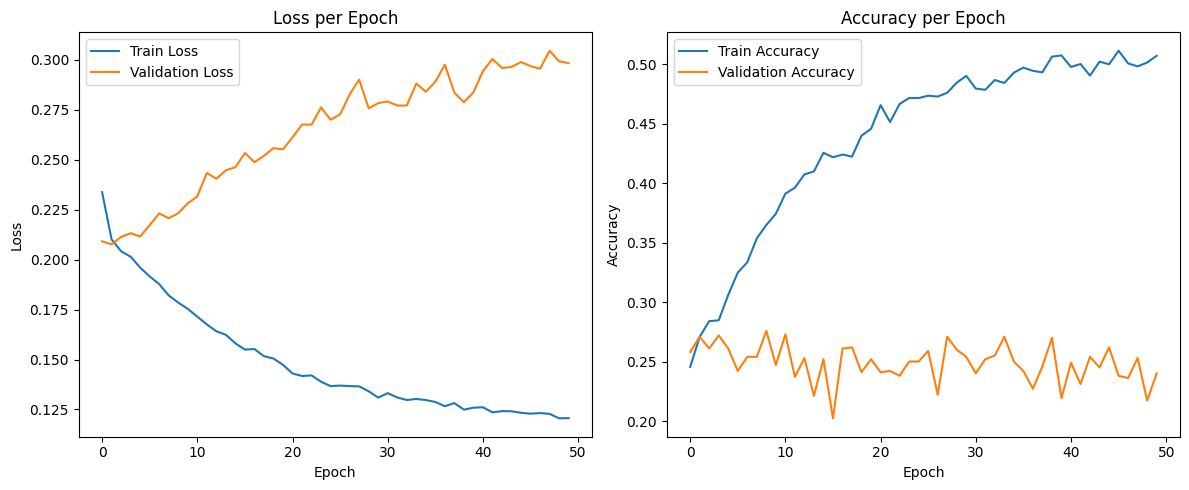

In [ ]:
# @title
import matplotlib.pyplot as plt

# Plot Loss and Accuracy curves
plt.figure(figsize=(12,5))

# Loss plot
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# @title
# ================================
# 5. Build the Multi-Input Model
# ================================
from tensorflow.keras.layers import Input, TimeDistributed, GlobalAveragePooling2D, GlobalAveragePooling1D, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0
  # Import Con
# Input for images: shape (3, 224, 224, 3)
image_input = Input(shape=(MAX_IMAGES, 224, 224, 3), name='image_input')
# Process each image with a CNN (using TimeDistributed)
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False  # Freeze base weights

# Apply the CNN to each image in the sequence
cnn_out = TimeDistributed(base_model)(image_input)
cnn_out = TimeDistributed(GlobalAveragePooling2D())(cnn_out)  # Shape: (batch, 3, feature_dim)
# Pool over the images (time dimension) to get a single feature vector per case.
image_features = GlobalAveragePooling1D()(cnn_out)  # Shape: (batch, feature_dim)

# Input for metadata
meta_input = Input(shape=(X_meta_train.shape[1],), name='meta_input')
meta_features = Dense(128, activation='relu')(meta_input)

# Combine image features and metadata features
combined = Concatenate()([image_features, meta_features])
x = Dense(128, activation='relu')(combined)
output = Dense(8, activation='sigmoid')(x)  # Multi-label output with sigmoid

model = Model(inputs=[image_input, meta_input], outputs=output)
model.compile(tf.keras.optimizers.AdamW(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy']) # Changed loss to categorical_crossentropy
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)  │ (None, 3, 224, 224, 3) │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_4        │ (None, 3, 7, 7, 1280)  │      4,049,571 │ image_input[0][0]      │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_5        │ (None, 3, 1280)        │              0 │ time_distributed_4[0]… │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ meta_input (InputLayer)   │ (None, 66)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 1280)           │              0 │ time_distributed_5[0]… │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 128)            │          8,576 │ meta_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 1408)           │              0 │ global_average_poolin… │
│ (Concatenate)             │                        │                │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 128)            │        180,352 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 8)              │          1,032 │ dense_7[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,239,531 (16.17 MB)

 Trainable params: 189,960 (742.03 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
# @title
history = model.fit(
    [X_train, X_meta_train], y_train,
    validation_data=([X_test, X_meta_test], y_test),
    epochs=20,
    batch_size=32
)

Epoch 1/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 104s 397ms/step - accuracy: 0.0280 - loss: nan - val_accuracy: 0.0218 - val_loss: nan
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.0224 - loss: nan - val_accuracy: 0.0218 - val_loss: nan
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.0280 - loss: nan - val_accuracy: 0.0218 - val_loss: nan
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.0275 - loss: nan - val_accuracy: 0.0218 - val_loss: nan
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.0230 - loss: nan - val_accuracy: 0.0218 - val_loss: nan
Epoch 6/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.0249 - loss: nan - val_accuracy: 0.0218 - val_loss: nan
Epoch 7/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.0200 - loss: nan - val_accuracy: 0.0218 - val_loss: nan
Epoch 8/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.0224 - loss: nan - val_accuracy: 0.0218 - val_loss: nan
Epoch 9/20
12

In [ ]:
# @title
# prompt: save the model

# Save the model
model.save('/content/drive/MyDrive/dataset/skin_condition_model')


##### Split the dataset for yolo training

In [ ]:
import os
import shutil
import pandas as pd
import ast

# Define paths
source_dir = "/content/drive/MyDrive/extracted_data/images/"  # Actual image directory
dataset_dir = "/content/drive/MyDrive/yolov8_dataset/"  # Destination for YOLO dataset

scin_cases_path = "/content/drive/MyDrive/extracted_data/scin_cases.csv"
scin_labels_path = "/content/drive/MyDrive/extracted_data/scin_labels.csv"

# Load datasets
scin_cases = pd.read_csv(scin_cases_path)
scin_labels = pd.read_csv(scin_labels_path)

# Merge both datasets on 'case_id'
scin_data = scin_cases.merge(scin_labels, on="case_id")

# Function to determine dominant skin condition
def get_dominant_condition(row):
    try:
        conditions = ast.literal_eval(row["dermatologist_skin_condition_on_label_name"]) if isinstance(row["dermatologist_skin_condition_on_label_name"], str) else row["dermatologist_skin_condition_on_label_name"]
        confidences = ast.literal_eval(row["dermatologist_skin_condition_confidence"]) if isinstance(row["dermatologist_skin_condition_confidence"], str) else row["dermatologist_skin_condition_confidence"]

        if isinstance(conditions, list) and isinstance(confidences, list) and len(conditions) == len(confidences) and len(conditions) > 0:
            return max(zip(conditions, confidences), key=lambda x: x[1])[0]  # Get highest confidence condition
    except (ValueError, SyntaxError, TypeError) as e:
        print(f"Error processing row {row.name}: {e}")
        return None

# Apply function to dataset
scin_data["dominant_skin_condition"] = scin_data.apply(get_dominant_condition, axis=1)

# Drop rows where dominant condition is missing
scin_data = scin_data.dropna(subset=["dominant_skin_condition"])

# Create YOLO dataset folders
split_ratios = {"train": 0.8, "val": 0.1, "test": 0.1}
for split in split_ratios:
    os.makedirs(os.path.join(dataset_dir, "images", split), exist_ok=True)
    os.makedirs(os.path.join(dataset_dir, "labels", split), exist_ok=True)

# Flatten images per case to ensure each image is stored under the dominant condition
image_columns = ["image_1_path", "image_2_path", "image_3_path"]
all_images = scin_data.melt(id_vars=["dominant_skin_condition"], value_vars=image_columns, var_name="image_type", value_name="image_path").dropna()

# Remove spaces in class names
all_images["dominant_skin_condition"] = all_images["dominant_skin_condition"].str.replace(" ", "_")

# Extract filename from image path and prepend correct source directory
all_images["image_path"] = all_images["image_path"].apply(lambda x: os.path.join(source_dir, os.path.basename(x)))

# Shuffle dataset while maintaining class balance
all_images = all_images.groupby("dominant_skin_condition", group_keys=False).apply(lambda x: x.sample(frac=1, random_state=42)).reset_index(drop=True)

# Perform stratified split for balanced distribution
train_count = int(len(all_images) * split_ratios["train"])
val_count = int(len(all_images) * split_ratios["val"])

train_data = all_images[:train_count]
val_data = all_images[train_count:train_count + val_count]
test_data = all_images[train_count + val_count:]

# Function to move images into class-wise folders
def move_images(split_name, split_data):
    for _, row in split_data.iterrows():
        img_src = row["image_path"]
        class_name = row["dominant_skin_condition"]

        split_path = os.path.join(dataset_dir, "images", split_name, class_name)
        os.makedirs(split_path, exist_ok=True)  # Create class-wise subfolder

        img_dst = os.path.join(split_path, os.path.basename(img_src))

        # Check if source file exists before copying
        if not os.path.exists(img_src):
            print(f"⚠️ Warning: Image not found: {img_src}")
            continue

        try:
            shutil.copy(img_src, img_dst)  # Copy instead of move
        except Exception as e:
            print(f"❌ Error copying {img_src}: {e}")

# Organize dataset
move_images("train", train_data)
move_images("val", val_data)
move_images("test", test_data)

print("✅ Dataset successfully prepared for YOLOv8 Classification!")


<ipython-input-5-0fea0d45548a>:55: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  all_images = all_images.groupby("dominant_skin_condition", group_keys=False).apply(lambda x: x.sample(frac=1, random_state=42)).reset_index(drop=True)


⚠️ Warning: Image not found: /content/drive/MyDrive/extracted_data/images/-2243186711511406658.png
✅ Dataset successfully prepared for YOLOv8 Classification!


In [ ]:
!ls /content/drive/MyDrive/yolov8_dataset/images/train | wc -l  # Count training images
!ls /content/drive/MyDrive/yolov8_dataset/images/val | wc -l  # Count validation images
!ls /content/drive/MyDrive/yolov8_dataset/images/test | wc -l  # Count test images


164
25
19


In [ ]:
# Check unique values to ensure it's working correctly
scin_data["dominant_skin_condition"].unique()

array(['Inflicted skin lesions', 'Prurigo nodularis', 'Impetigo', None,
       'Lichen planus/lichenoid eruption', 'Drug Rash', 'Urticaria',
       'Basal Cell Carcinoma', 'Eczema', 'Purpura', 'Skin infection',
       'Tinea Versicolor', 'Stasis Dermatitis', 'Hyperpigmentation',
       'Psoriasis', 'Infected eczema', 'Pityriasis rosea', 'Tinea',
       'Onychodystrophy', 'Folliculitis', 'Chronic dermatitis, NOS',
       'Acute and chronic dermatitis', 'Sweet syndrome', 'Insect Bite',
       'Allergic Contact Dermatitis', 'Herpes Simplex',
       'Fox-Fordyce disease', 'Pigmented purpuric eruption', 'Cyst',
       'Granuloma annulare', 'Herpes Zoster', 'Verruca vulgaris',
       'Confluent and reticulate papillomatosis', 'Photodermatitis',
       'Molluscum Contagiosum', 'Contact purpura', 'Xerosis', 'Acne',
       'Abscess', 'Rosacea', 'Miliaria', 'Abrasion, scrape, or scab',
       'wound/abrasion', 'Irritant Contact Dermatitis',
       'O/E - ecchymoses present', 'Erosion of skin', '

In [ ]:
missing_count = scin_data["dominant_skin_condition"].isna().sum()
total_rows = len(scin_data)

print(f"Missing dominant conditions: {missing_count} out of {total_rows}")


Missing dominant conditions: 1972 out of 5033


In [ ]:
import pandas as pd

# Display all columns and rows
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Adjust width to prevent wrapping
pd.set_option('display.max_colwidth', None)  # Show full cell content


In [ ]:
# Count images per row
scin_data["image_count"] = scin_data[["image_1_path", "image_2_path", "image_3_path"]].notna().sum(axis=1)

# Group by dominant condition and sum the images
condition_image_counts = scin_data.groupby("dominant_skin_condition")["image_count"].sum().reset_index()

# Sort by highest count
condition_image_counts = condition_image_counts.sort_values(by="image_count", ascending=False)

# Display the top results
condition_image_counts

,dominant_skin_condition,image_count
56,Eczema,1042
19,Allergic Contact Dermatitis,546
196,Urticaria,442
96,Insect Bite,392
68,Folliculitis,301
190,Tinea,216
167,Psoriasis,215
90,Impetigo,139
84,Herpes Zoster,135
154,Pigmented purpuric eruption,131


Some of the categories have just 1 image and Eczema condition is dominant in this dataset (1042 images). with this imbalance, we cannot oversample for minority classes using augmentation as that will increase the size of data drastically and impact training times.

Its better to recategorize and try YOLO on fewer categories

# HAM10000

In [ ]:


import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
import numpy as np
from sklearn.model_selection import train_test_split
import os, cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, GlobalAveragePooling2D, Dropout
from google.colab.patches import cv2_imshow
from tensorflow.keras.applications import ResNet50, MobileNetV2

from tensorflow.keras.optimizers import Adam



In [ ]:


import pandas as pd
data = pd.read_csv('/content/drive/MyDrive/HAM10000/hmnist_28_28_RGB.csv/hmnist_28_28_RGB.csv')
data.head()



,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,...,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,...,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,...,209,166,185,172,135,149,109,78,92,2


In [ ]:


y = data['label']
x = data.drop(columns = ['label'])



In [ ]:
tabular_data = pd.read_csv('/content/drive/MyDrive/HAM10000/HAM10000_metadata.csv')
tabular_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [ ]:


classes = {4: ('nv', ' melanocytic nevi'), 6: ('mel', 'melanoma'), 2 :('bkl', 'benign keratosis-like lesions'), 1:('bcc' , ' basal cell carcinoma'), 5: ('vasc', ' pyogenic granulomas and hemorrhage'), 0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),  3: ('df', 'dermatofibroma')}



Text(0.5, 1.0, 'Frequency Distribution of Classes')

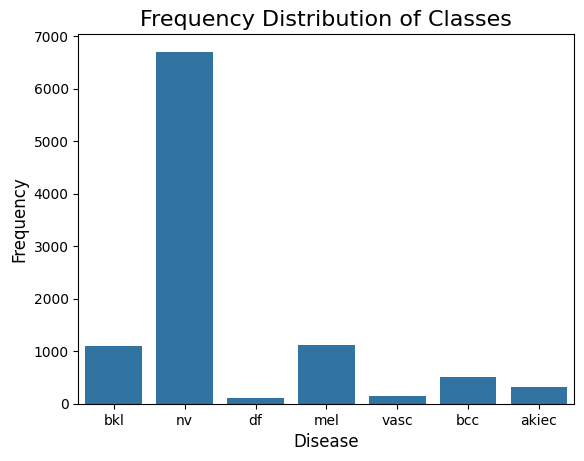

In [ ]:


sns.countplot(x = 'dx', data = tabular_data)
plt.xlabel('Disease', size=12)
plt.ylabel('Frequency', size=12)
plt.title('Frequency Distribution of Classes', size=16)



Text(0.5, 1.0, 'Gender of Patient')

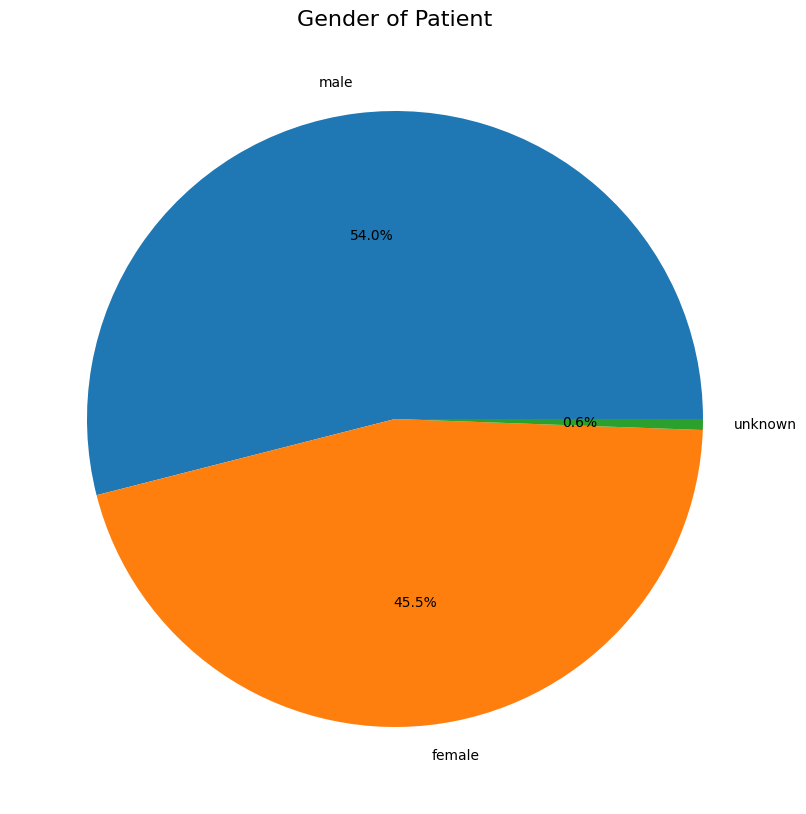

In [ ]:
bar, ax = plt.subplots(figsize = (10,10))
plt.pie(tabular_data['sex'].value_counts(), labels = tabular_data['sex'].value_counts().index, autopct="%.1f%%")
plt.title('Gender of Patient', size=16)

Text(0.5, 1.0, 'Histogram of Age of Patients')

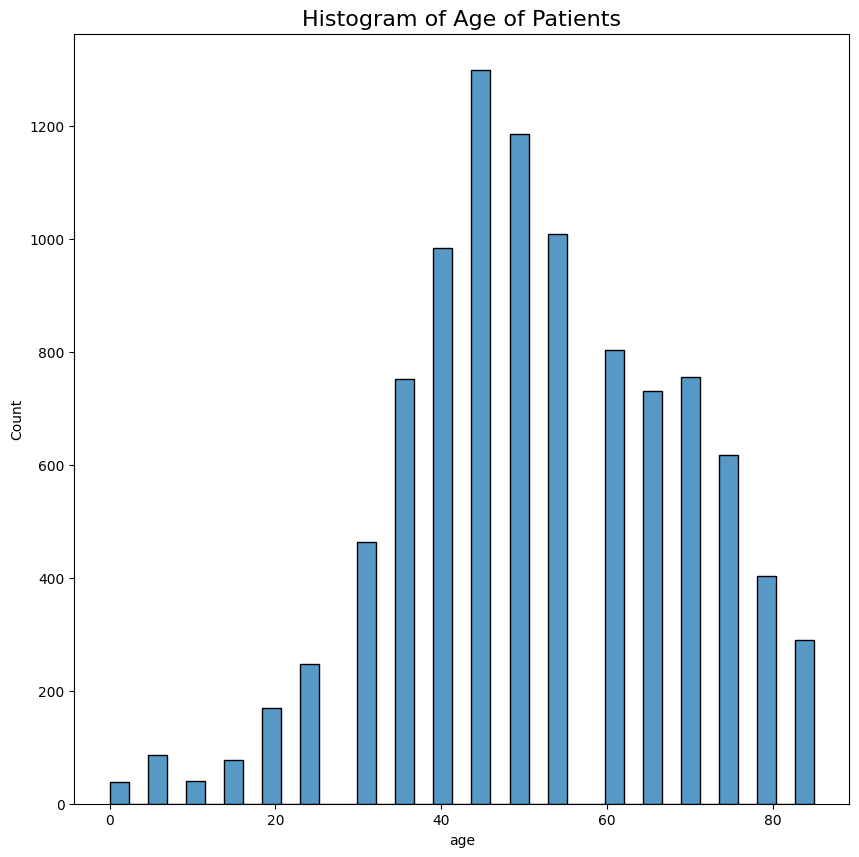

In [ ]:


bar, ax = plt.subplots(figsize=(10,10))
sns.histplot(tabular_data['age'])
plt.title('Histogram of Age of Patients', size=16)



([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 [Text(0, 0, 'back'),
  Text(1, 0, 'lower extremity'),
  Text(2, 0, 'trunk'),
  Text(3, 0, 'upper extremity'),
  Text(4, 0, 'abdomen'),
  Text(5, 0, 'face'),
  Text(6, 0, 'chest'),
  Text(7, 0, 'foot'),
  Text(8, 0, 'scalp'),
  Text(9, 0, 'neck'),
  Text(10, 0, 'unknown'),
  Text(11, 0, 'hand'),
  Text(12, 0, 'genital'),
  Text(13, 0, 'ear'),
  Text(14, 0, 'acral')])

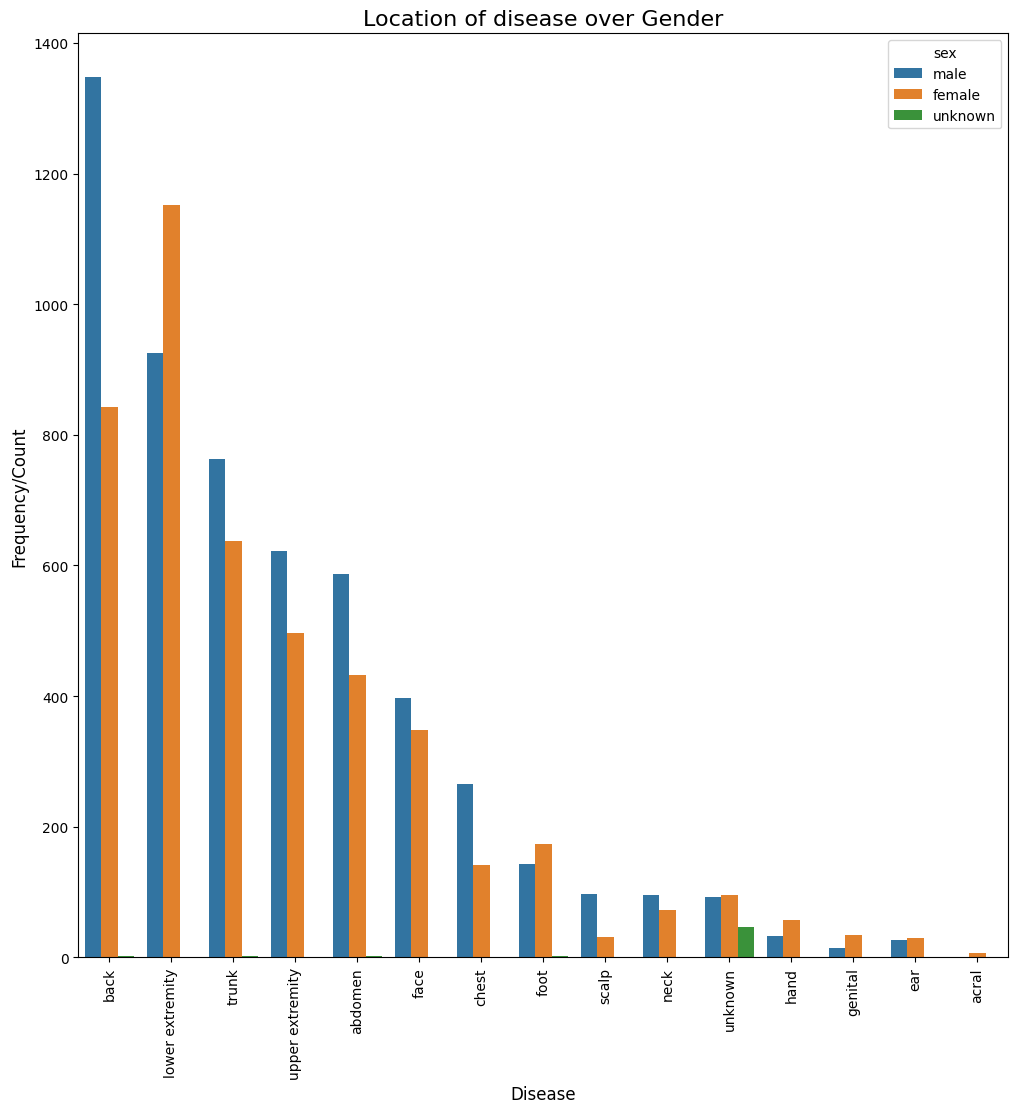

In [ ]:


value = tabular_data[['localization', 'sex']].value_counts().to_frame()
value.reset_index(level=[1,0 ], inplace=True)
temp = value.rename(columns = {'localization':'location', 0: 'count'})

bar, ax = plt.subplots(figsize = (12, 12))
sns.barplot(x = 'location',  y='count', hue = 'sex', data = temp)
plt.title('Location of disease over Gender', size = 16)
plt.xlabel('Disease', size=12)
plt.ylabel('Frequency/Count', size=12)
plt.xticks(rotation = 90)



([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 [Text(0, 0, 'back'),
  Text(1, 0, 'lower extremity'),
  Text(2, 0, 'trunk'),
  Text(3, 0, 'upper extremity'),
  Text(4, 0, 'abdomen'),
  Text(5, 0, 'face'),
  Text(6, 0, 'chest'),
  Text(7, 0, 'foot'),
  Text(8, 0, 'scalp'),
  Text(9, 0, 'neck'),
  Text(10, 0, 'unknown'),
  Text(11, 0, 'hand'),
  Text(12, 0, 'genital'),
  Text(13, 0, 'ear'),
  Text(14, 0, 'acral')])

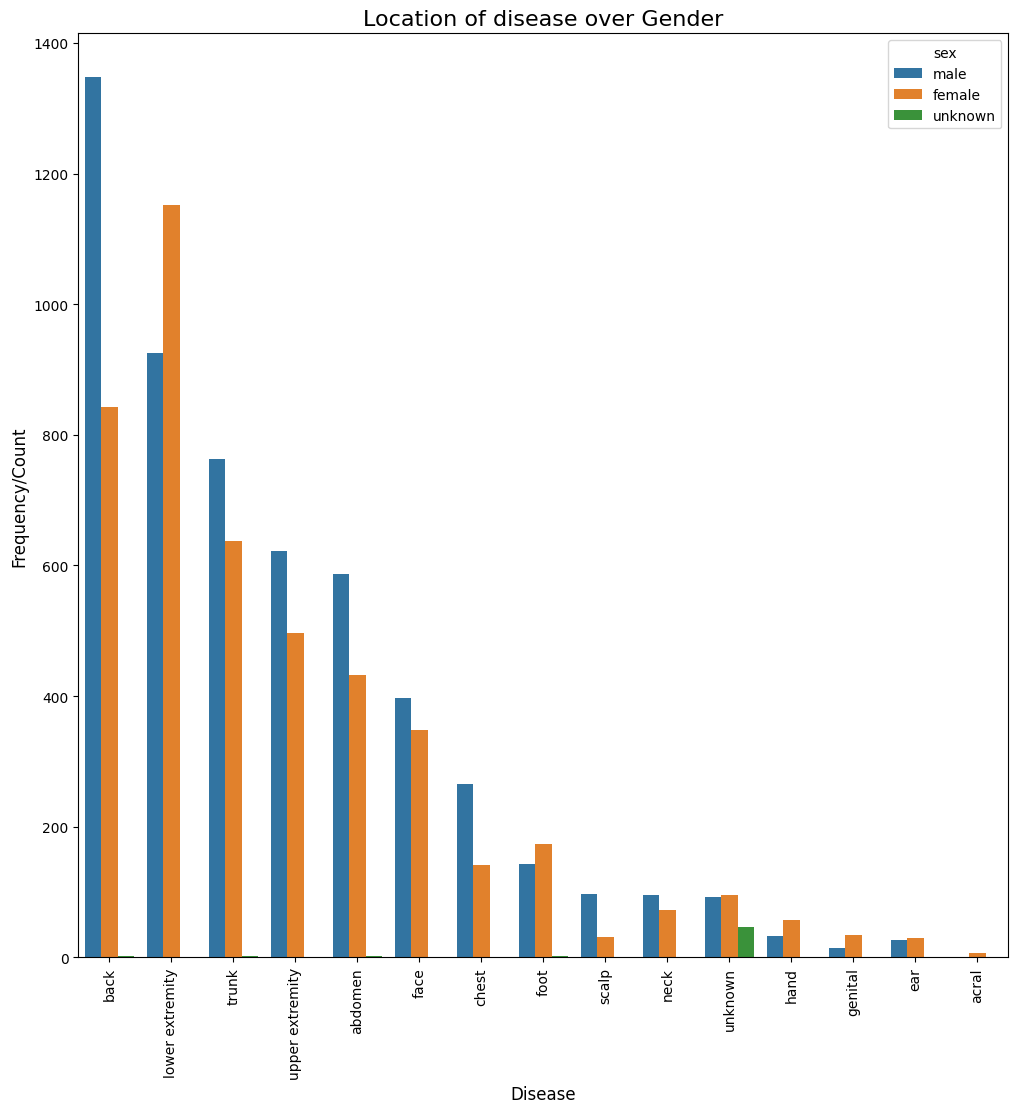

In [ ]:


value = tabular_data[['localization', 'sex']].value_counts().to_frame()
value.reset_index(level=[1,0 ], inplace=True)
temp = value.rename(columns = {'localization':'location', 0: 'count'})

bar, ax = plt.subplots(figsize = (12, 12))
sns.barplot(x = 'location',  y='count', hue = 'sex', data = temp)
plt.title('Location of disease over Gender', size = 16)
plt.xlabel('Disease', size=12)
plt.ylabel('Frequency/Count', size=12)
plt.xticks(rotation = 90)



In [ ]:
oversample = RandomOverSampler()
x,y  = oversample.fit_resample(x,y)



In [ ]:
x = np.array(x).reshape(-1,28,28,3)
print('Shape of X :',x.shape)



Shape of X : (46935, 28, 28, 3)


In [ ]:
x = (x-np.mean(x))/np.std(x)
X_train, X_test, Y_train, Y_test = train_test_split(x,y, test_size=0.2, random_state=1)



In [ ]:
model = Sequential()
model.add(Conv2D(16, kernel_size = (3,3), input_shape = (28, 28, 3), activation = 'relu', padding = 'same'))
model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(7, activation='softmax'))
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 26, 26, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 13, 13, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 64)                  │         147,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 7)                   │             231 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 182,663 (713.53 KB)

 Trainable params: 182,663 (713.53 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
callback = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5',
                                                  monitor='val_acc', mode='max',
                                                 verbose=1)



In [ ]:
optimizer = Adam(learning_rate=0.0001)

In [ ]:
model.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = 'adam',
              metrics = ['accuracy'])
history = model.fit(X_train,
                    Y_train,
                    validation_split=0.2,
                    batch_size = 128,
                    epochs = 20,
                    callbacks=[callback])

Epoch 1/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3827 - loss: 1.5511
Epoch 1: saving model to best_model.h5


235/235 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.3832 - loss: 1.5500 - val_accuracy: 0.6594 - val_loss: 0.8926
Epoch 2/20
230/235 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6969 - loss: 0.7973
Epoch 2: saving model to best_model.h5


235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6979 - loss: 0.7950 - val_accuracy: 0.8063 - val_loss: 0.5519
Epoch 3/20
227/235 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8229 - loss: 0.4919
Epoch 3: saving model to best_model.h5


235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8234 - loss: 0.4905 - val_accuracy: 0.8623 - val_loss: 0.3717
Epoch 4/20
226/235 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8781 - loss: 0.3338
Epoch 4: saving model to best_model.h5


235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8785 - loss: 0.3330 - val_accuracy: 0.9063 - val_loss: 0.2672
Epoch 5/20
228/235 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9164 - loss: 0.2350
Epoch 5: saving model to best_model.h5


235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9164 - loss: 0.2349 - val_accuracy: 0.9089 - val_loss: 0.2599
Epoch 6/20
224/235 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9334 - loss: 0.1908
Epoch 6: saving model to best_model.h5


235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9334 - loss: 0.1907 - val_accuracy: 0.9269 - val_loss: 0.2132
Epoch 7/20
231/235 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9513 - loss: 0.1357
Epoch 7: saving model to best_model.h5


235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9512 - loss: 0.1359 - val_accuracy: 0.9394 - val_loss: 0.1764
Epoch 8/20
229/235 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9586 - loss: 0.1154
Epoch 8: saving model to best_model.h5


235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9586 - loss: 0.1154 - val_accuracy: 0.9296 - val_loss: 0.2005
Epoch 9/20
231/235 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9654 - loss: 0.0979
Epoch 9: saving model to best_model.h5


235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9654 - loss: 0.0979 - val_accuracy: 0.9357 - val_loss: 0.1982
Epoch 10/20
232/235 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9693 - loss: 0.0829
Epoch 10: saving model to best_model.h5


235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9692 - loss: 0.0830 - val_accuracy: 0.9513 - val_loss: 0.1745
Epoch 11/20
228/235 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9752 - loss: 0.0759
Epoch 11: saving model to best_model.h5


235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9751 - loss: 0.0761 - val_accuracy: 0.9435 - val_loss: 0.1828
Epoch 12/20
230/235 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9775 - loss: 0.0641
Epoch 12: saving model to best_model.h5


235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9773 - loss: 0.0646 - val_accuracy: 0.9298 - val_loss: 0.2490
Epoch 13/20
228/235 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9736 - loss: 0.0718
Epoch 13: saving model to best_model.h5


235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9739 - loss: 0.0711 - val_accuracy: 0.9411 - val_loss: 0.2068
Epoch 14/20
232/235 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9768 - loss: 0.0655
Epoch 14: saving model to best_model.h5


235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9769 - loss: 0.0653 - val_accuracy: 0.9590 - val_loss: 0.1486
Epoch 15/20
230/235 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9849 - loss: 0.0426
Epoch 15: saving model to best_model.h5


235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9850 - loss: 0.0424 - val_accuracy: 0.9668 - val_loss: 0.1477
Epoch 16/20
225/235 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9945 - loss: 0.0177
Epoch 16: saving model to best_model.h5


235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9942 - loss: 0.0185 - val_accuracy: 0.9174 - val_loss: 0.3363
Epoch 17/20
227/235 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9676 - loss: 0.0903
Epoch 17: saving model to best_model.h5


235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9680 - loss: 0.0893 - val_accuracy: 0.9664 - val_loss: 0.1245
Epoch 18/20
227/235 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9908 - loss: 0.0304
Epoch 18: saving model to best_model.h5


235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9908 - loss: 0.0304 - val_accuracy: 0.9634 - val_loss: 0.1297
Epoch 19/20
233/235 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9915 - loss: 0.0240
Epoch 19: saving model to best_model.h5


235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9915 - loss: 0.0240 - val_accuracy: 0.9581 - val_loss: 0.1584
Epoch 20/20
228/235 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9833 - loss: 0.0527
Epoch 20: saving model to best_model.h5


235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9832 - loss: 0.0528 - val_accuracy: 0.9711 - val_loss: 0.1400


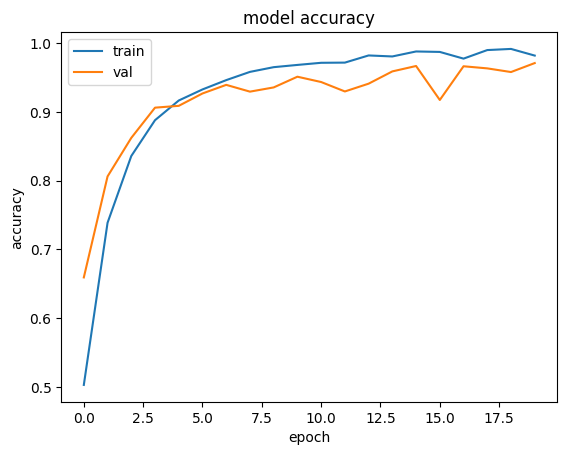

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

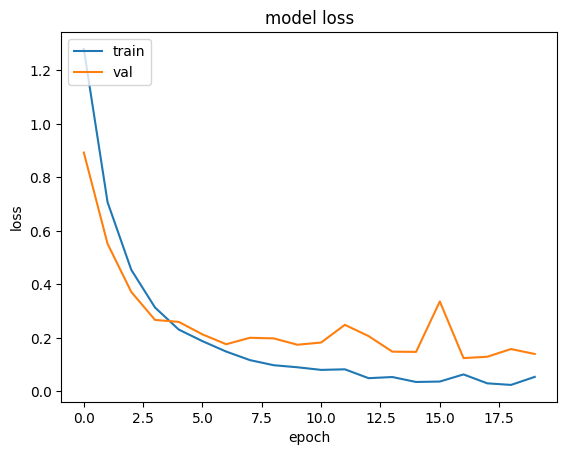

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model.load_weights('best_model.h5')

In [ ]:
loss, acc = model.evaluate(X_test, Y_test, verbose=2)

294/294 - 2s - 8ms/step - accuracy: 0.9678 - loss: 0.1573
